In [63]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from scipy import stats
from sklearn.cluster import KMeans

In [64]:
pd.set_option('mode.chained_assignment', None) # switch off the SettingWithCopyWarning warning

In [65]:
isColab = False

In [66]:
if isColab:
  from google.colab import drive
  drive.mount('/content/drive/')

  dataset = pd.read_csv('/content/drive/MyDrive/Data/london_merged.csv')
else:
 dataset = pd.read_csv('./london_merged.csv')

# Opis danych

#### Zbiór danych zawiera następujące kolumny:
- `timestamp` - znacznik czasowy
- `cnt` - liczba nowych wypożyczeń rowerów
- `t1` - temperatura w stopniach Celsjusza
- `t2` - temperatura odczuwalna w stopniach Celsjusza
- `hum` - wilgotność powietrza (skala procentowa)
- `wind_speed` - pędkość wiatru w $\frac{km}{h}$
- `weather_code` - kategoria pogody w kategoriach:
    - 1 - Czyste niebo / czyste z nielicznymi zjawiskami, jak lekka mgła itp.
    - 2 - Obecne chmury
    - 3 - Promienie przedzierające się przez chmury (chmury pokrywające 60-90 % nieba)
    - 4 - Pochmurno
    - 7 - Deszcz/mżawka
    - 10 - Deszcz z burzą
    - 26 - Opad śniegu
    - 94 - mgła lodowa
- `is_holiday` - oznacza święto/wakacje w danym dniu (1  oznacza święto, zero jego brak)
- `is_weekend` - oznacza dzień zaliczany do weekendu (1 weekend, 0 jego brak)
- `season` - określenie pory roku:
    - 0 - wiosna
    - 1 - lato
    - 2 - jesień
    - 3 - zima

#### Przykładowy wycinek z danych

In [67]:
dataset.head()

timestamp  cnt   t1   t2    hum  wind_speed  weather_code  is_holiday  is_weekend  season
0  2015-01-04 00:00:00  182  3.0  2.0   93.0         6.0           3.0         0.0         1.0     3.0
1  2015-01-04 01:00:00  138  3.0  2.5   93.0         5.0           1.0         0.0         1.0     3.0
2  2015-01-04 02:00:00  134  2.5  2.5   96.5         0.0           1.0         0.0         1.0     3.0
3  2015-01-04 03:00:00   72  2.0  2.0  100.0         0.0           1.0         0.0         1.0     3.0
4  2015-01-04 04:00:00   47  2.0  0.0   93.0         6.5           1.0         0.0         1.0     3.0

#### Liczność danych (kolumny x wiersze)

In [68]:
f"{dataset.shape[1]} kolumn x {dataset.shape[0]} wierszy"

'10 kolumn x 17414 wierszy'

In [69]:
def get_unit(col):
    units = {'t1': r' [$^{\circ}$C]', 'wind_speed': r' [$\frac{km}{h}$]', 'hum':' [%]'}
    if col in units.keys():
        return units[col]
    else:
        return ""

# Wstępna charakterystyka i walidacja danych

Wstępna charakterystyka danych może od samego początku wskazać błędy w danych. Wnioskowanie można przeprowadzić ze względu na naturalne ograniczenia parametrów:
- `temperatura` w przedziale <-50, 50> &deg;C
- `wilgotność` powietza w przedziale <0,100> %
- `prędkość` wiatru w przedziale <0, 250> $\frac{km}{h}$

Ich poprawność wg w.w kryteriów można określić za pomocą tabeli podsumowania danych na podstawie wartości `min` oraz `max`.

In [70]:
dataset.describe()

cnt            t1            t2           hum    wind_speed  weather_code    is_holiday    is_weekend        season
count  17414.000000  17414.000000  17414.000000  17414.000000  17414.000000  17414.000000  17414.000000  17414.000000  17414.000000
mean    1143.101642     12.468091     11.520836     72.324954     15.913063      2.722752      0.022051      0.285403      1.492075
std     1085.108068      5.571818      6.615145     14.313186      7.894570      2.341163      0.146854      0.451619      1.118911
min        0.000000     -1.500000     -6.000000     20.500000      0.000000      1.000000      0.000000      0.000000      0.000000
25%      257.000000      8.000000      6.000000     63.000000     10.000000      1.000000      0.000000      0.000000      0.000000
50%      844.000000     12.500000     12.500000     74.500000     15.000000      2.000000      0.000000      0.000000      1.000000
75%     1671.750000     16.000000     16.000000     83.000000     20.500000      3.000000      0.000000      1.000000      2.000000
max     7860.000000     34.000000     34.000000    100.000000     56.500000     26.000000      1.000000      1.000000      3.000000

Pozostałe atrybuty to wartości dyskretne ze ściśle określonych zbiorów:
- `weather_code` $\in \{1,2,3,4,7,10,26,94\}$
- `is_holiday` $\in \{0,1\}$
- `is_weekend` $\in \{0,1\}$
- `season` $\in \{0,1,2,3\}$

Ich poprawność można określić poprzez sprawdzenie, czy wartości zawierają się w zadanych zbiorach.

In [71]:
weather_code_validation_set = (1, 2, 3, 4, 7, 10, 26, 94)
is_holiday_validation_set = (0, 1)
is_weekend_validation_set = (0, 1)
season_validation_set = (0, 1, 2, 3)

validation_sets = {'weather_code': weather_code_validation_set, 'is_holiday': is_holiday_validation_set,
                   'is_weekend': is_weekend_validation_set, 'season': season_validation_set}

dataset[validation_sets.keys()].isin(validation_sets).all(axis=0)



weather_code    True
is_holiday      True
is_weekend      True
season          True
dtype: bool

#### Statystyka danych brakujących (NULL)

In [72]:
dataset.isna().any(axis=0)

timestamp       False
cnt             False
t1              False
t2              False
hum             False
wind_speed      False
weather_code    False
is_holiday      False
is_weekend      False
season          False
dtype: bool

Test wykazuje brak danych o wartościach nieokreślonych

#### Wnioski
Wstępne testy wykazały poprawność formalną danych, spełniają określone założenia, tj. ich wartości mieszczą się w zadanych przedziałach, a dla wartości dyskretnych - w zbiorach.

# Badanie wartości nietypowych

## Metoda 3 - sigma

In [73]:
outliers_3_score = np.where(
    np.abs(stats.zscore(dataset[dataset.keys().drop('timestamp')])) > 3)

outliered_dataset = dataset.iloc[outliers_3_score[0]]

sorted_outliers = sorted(zip(outliers_3_score[0], outliers_3_score[1]), key=lambda x: x[1])
outliers_3_sigma = {}

#### `Cnt` outliers

In [74]:
outliers_3_sigma['cnt'] = dataset.iloc[list(map(lambda x: x[0],filter(lambda x: x[1] == 0, sorted_outliers)))]
outliers_3_sigma['cnt']

timestamp   cnt    t1    t2   hum  wind_speed  weather_code  is_holiday  is_weekend  season
2433   2015-04-15 17:00:00  4446  23.5  22.5  29.0        19.5           1.0         0.0         0.0     0.0
2434   2015-04-15 18:00:00  4492  22.5  21.5  32.5        18.0           1.0         0.0         0.0     0.0
2568   2015-04-21 08:00:00  4628   9.5   8.5  66.5         9.0           1.0         0.0         0.0     0.0
2592   2015-04-22 08:00:00  4443   8.5   6.5  76.5        14.0           1.0         0.0         0.0     0.0
2712   2015-04-27 08:00:00  4437   7.0   5.0  68.5        10.0           1.0         0.0         0.0     0.0
2736   2015-04-28 08:00:00  4453   8.0   4.0  59.5        28.0           2.0         0.0         0.0     0.0
3072   2015-05-12 08:00:00  4413  13.0  13.0  63.0        22.0           2.0         0.0         0.0     0.0
3096   2015-05-13 08:00:00  4675  13.0  13.0  59.0         2.0           1.0         0.0         0.0     0.0
3264   2015-05-20 08:00:00  4428  10.5   9.0  64.5        21.0           2.0         0.0         0.0     0.0
3600   2015-06-03 08:00:00  4607  15.0  15.0  59.0        25.0           2.0         0.0         0.0     1.0
3624   2015-06-04 08:00:00  4581  16.0  16.0  52.0         7.5           1.0         0.0         0.0     1.0
3717   2015-06-08 08:00:00  4507  14.0  14.0  63.0         7.0           1.0         0.0         0.0     1.0
3741   2015-06-09 08:00:00  4615  12.0  12.0  60.5        25.0           2.0         0.0         0.0     1.0
3765   2015-06-10 08:00:00  4694  12.5  12.5  61.0        20.5           3.0         0.0         0.0     1.0
3789   2015-06-11 08:00:00  4723  16.5  16.5  68.0        24.0           1.0         0.0         0.0     1.0
3885   2015-06-15 08:00:00  4447  13.0  13.0  67.0        21.0           3.0         0.0         0.0     1.0
3909   2015-06-16 08:00:00  4749  14.5  14.5  49.5         6.0           1.0         0.0         0.0     1.0
3933   2015-06-17 08:00:00  4803  17.0  17.0  68.0        21.5           2.0         0.0         0.0     1.0
3957   2015-06-18 08:00:00  4622  15.0  15.0  63.0        18.0           2.0         0.0         0.0     1.0
4077   2015-06-23 08:00:00  4685  14.0  14.0  67.0        19.0           3.0         0.0         0.0     1.0
4101   2015-06-24 08:00:00  4568  17.0  17.0  61.5        16.0           1.0         0.0         0.0     1.0
4125   2015-06-25 08:00:00  4543  18.0  18.0  64.0        10.0           1.0         0.0         0.0     1.0
4230   2015-06-29 17:00:00  4464  25.5  25.5  39.5        15.0           1.0         0.0         0.0     1.0
4231   2015-06-29 18:00:00  4727  25.5  25.5  38.0        12.0           1.0         0.0         0.0     1.0
4245   2015-06-30 08:00:00  4829  21.5  21.0  45.0        10.0           1.0         0.0         0.0     1.0
4254   2015-06-30 17:00:00  4657  27.0  27.0  42.0        25.0           1.0         0.0         0.0     1.0
4255   2015-06-30 18:00:00  4930  25.5  25.5  49.5        30.0           1.0         0.0         0.0     1.0
4269   2015-07-01 08:00:00  4779  24.5  24.5  55.5        17.0           1.0         0.0         0.0     1.0
4278   2015-07-01 17:00:00  4617  34.0  34.0  33.0        20.5           1.0         0.0         0.0     1.0
4279   2015-07-01 18:00:00  4604  34.0  34.0  33.0        20.5           1.0         0.0         0.0     1.0
4293   2015-07-02 08:00:00  4641  22.0  22.0  65.0         7.0           1.0         0.0         0.0     1.0
4317   2015-07-03 08:00:00  4412  19.5  19.5  54.5        13.0           1.0         0.0         0.0     1.0
4389   2015-07-06 08:00:00  4549  17.5  17.5  64.0        13.0           2.0         0.0         0.0     1.0
4398   2015-07-06 17:00:00  4501  23.0  22.0  41.0        18.0           1.0         0.0         0.0     1.0
4399   2015-07-06 18:00:00  4470  22.5  22.0  45.5        18.5           1.0         0.0         0.0     1.0
4413   2015-07-07 08:00:00  4867  19.5  19.5  66.0        13.0           2.0         0.0     

#### `t1` outliers

In [75]:
outliers_3_sigma['t1'] = dataset.iloc[list(map(lambda x: x[0],filter(lambda x: x[1] == 1, sorted_outliers)))]
outliers_3_sigma['t1']

timestamp   cnt    t1    t2   hum  wind_speed  weather_code  is_holiday  is_weekend  season
4271   2015-07-01 10:00:00  1299  30.0  30.0  43.0        20.0           1.0         0.0         0.0     1.0
4272   2015-07-01 11:00:00  1374  33.0  33.0  34.0        22.0           1.0         0.0         0.0     1.0
4273   2015-07-01 12:00:00  1654  32.0  32.0  36.0        19.5           1.0         0.0         0.0     1.0
4274   2015-07-01 13:00:00  1753  31.5  31.5  38.0        21.0           1.0         0.0         0.0     1.0
4275   2015-07-01 14:00:00  1710  33.0  33.0  34.0        18.0           1.0         0.0         0.0     1.0
4276   2015-07-01 15:00:00  1904  33.5  33.5  34.0        22.0           1.0         0.0         0.0     1.0
4277   2015-07-01 16:00:00  2575  33.5  33.5  35.0        21.0           1.0         0.0         0.0     1.0
4278   2015-07-01 17:00:00  4617  34.0  34.0  33.0        20.5           1.0         0.0         0.0     1.0
4279   2015-07-01 18:00:00  4604  34.0  34.0  33.0        20.5           1.0         0.0         0.0     1.0
4280   2015-07-01 19:00:00  2883  33.5  33.5  36.0        14.0           1.0         0.0         0.0     1.0
4281   2015-07-01 20:00:00  2061  31.5  31.0  36.5        17.5           1.0         0.0         0.0     1.0
4282   2015-07-01 21:00:00  1859  29.5  29.5  45.5        21.5           1.0         0.0         0.0     1.0
5518   2015-08-22 13:00:00  3692  30.0  30.0  40.0        18.0           1.0         0.0         1.0     1.0
5519   2015-08-22 14:00:00  3883  30.0  29.5  39.0        22.0           1.0         0.0         1.0     1.0
5520   2015-08-22 15:00:00  3963  30.0  29.0  36.5        23.0           1.0         0.0         1.0     1.0
13415  2016-07-19 11:00:00  1398  29.5  29.5  45.5        18.0           1.0         0.0         0.0     1.0
13416  2016-07-19 12:00:00  1721  30.5  30.5  43.0        19.0           1.0         0.0         0.0     1.0
13417  2016-07-19 13:00:00  1855  31.0  31.0  40.0        19.0           1.0         0.0         0.0     1.0
13418  2016-07-19 14:00:00  1907  32.0  32.0  38.0        18.0           1.0         0.0         0.0     1.0
13419  2016-07-19 15:00:00  2053  32.0  32.0  37.0        18.5           1.0         0.0         0.0     1.0
13420  2016-07-19 16:00:00  2919  32.0  32.0  36.0        19.5           1.0         0.0         0.0     1.0
13421  2016-07-19 17:00:00  5304  31.0  30.5  39.5        18.0           1.0         0.0         0.0     1.0
13443  2016-07-20 15:00:00  1922  29.5  30.5  50.0        21.0           2.0         0.0         0.0     1.0
13444  2016-07-20 16:00:00  2684  30.5  30.5  43.0        24.0           1.0         0.0         0.0     1.0
13445  2016-07-20 17:00:00  5046  30.0  29.5  39.0        26.0           1.0         0.0         0.0     1.0
13446  2016-07-20 18:00:00  4953  29.5  28.5  34.0        24.0           1.0         0.0         0.0     1.0
14251  2016-08-23 14:00:00  1890  29.5  29.0  37.5        18.0           1.0         0.0         0.0     1.0
14252  2016-08-23 15:00:00  2102  30.0  29.0  36.5        18.0           1.0         0.0         0.0     1.0
14253  2016-08-23 16:00:00  2712  30.0  29.0  36.5        17.0           1.0         0.0         0.0     1.0
14274  2016-08-24 13:00:00  1796  30.0  30.0  44.5         6.5           1.0         0.0         0.0     1.0
14275  2016-08-24 14:00:00  1788  31.0  31.0  41.5         5.0           1.0         0.0         0.0     1.0
14276  2016-08-24 15:00:00  1887  32.0  32.0  41.0         6.0           1.0         0.0         0.0     1.0
14277  2016-08-24 16:00:00  2727  32.5  32.5  37.0         5.0           1.0         0.0         0.0     1.0
14278  2016-08-24 17:00:00  4984  32.5  32.5  37.0        10.5           1.0         0.0         0.0     1.0
14279  2016-08-24 18:00:00  4916  30.5  30.5  40.5        14.0           1.0         0.0         0.0     1.0
14715  2016-09-13 11:00:00  1351  29.5  29.5  44.0        21.5           1.0         0.0     

#### `hum` outliers

In [76]:
outliers_3_sigma['hum'] = dataset.iloc[list(map(lambda x: x[0],filter(lambda x: x[1] == 3, sorted_outliers)))]
outliers_3_sigma['hum']

timestamp   cnt    t1    t2   hum  wind_speed  weather_code  is_holiday  is_weekend  season
1619   2015-03-12 13:00:00  1282  14.0  14.0  26.0        21.0           1.0         0.0         0.0     0.0
1620   2015-03-12 14:00:00  1192  13.0  13.0  27.0        22.0           1.0         0.0         0.0     0.0
2432   2015-04-15 16:00:00  2455  25.0  24.0  29.0        18.5           1.0         0.0         0.0     0.0
2433   2015-04-15 17:00:00  4446  23.5  22.5  29.0        19.5           1.0         0.0         0.0     0.0
2741   2015-04-28 13:00:00  1324  12.5  12.5  29.0        29.0           1.0         0.0         0.0     0.0
2742   2015-04-28 14:00:00  1253  13.5  13.5  29.0        28.0           1.0         0.0         0.0     0.0
2744   2015-04-28 16:00:00  1924  14.0  14.0  29.0        26.0           1.0         0.0         0.0     0.0
2745   2015-04-28 17:00:00  3794  13.5  13.5  28.5        29.0           1.0         0.0         0.0     0.0
3298   2015-05-21 18:00:00  3764  19.5  19.5  27.0        19.5           1.0         0.0         0.0     0.0
4248   2015-06-30 11:00:00  1325  26.0  25.0  26.0        14.0           1.0         0.0         0.0     1.0
4249   2015-06-30 12:00:00  1657  27.0  26.0  24.0        11.0           1.0         0.0         0.0     1.0
4250   2015-06-30 13:00:00  1845  28.5  27.0  20.5        13.0           1.0         0.0         0.0     1.0
4251   2015-06-30 14:00:00  1783  29.0  28.0  26.0        15.0           1.0         0.0         0.0     1.0
4469   2015-07-09 16:00:00  6033  23.0  22.0  26.0        11.0           1.0         0.0         0.0     1.0
4470   2015-07-09 17:00:00  7860  23.0  22.0  27.0        11.0           1.0         0.0         0.0     1.0
4471   2015-07-09 18:00:00  6913  22.5  21.5  29.0        13.0           1.0         0.0         0.0     1.0
4472   2015-07-09 19:00:00  4654  22.0  21.0  29.0         7.0           1.0         0.0         0.0     1.0
4491   2015-07-10 14:00:00  2188  25.5  24.5  28.0        15.0           1.0         0.0         0.0     1.0
4492   2015-07-10 15:00:00  2391  26.0  25.0  23.5        14.0           1.0         0.0         0.0     1.0
4493   2015-07-10 16:00:00  3122  26.0  25.0  25.0        18.0           1.0         0.0         0.0     1.0
4494   2015-07-10 17:00:00  4453  25.5  24.5  26.0        18.0           1.0         0.0         0.0     1.0
4495   2015-07-10 18:00:00  3836  24.5  23.5  26.5        15.0           1.0         0.0         0.0     1.0
4710   2015-07-19 18:00:00  2978  24.0  23.0  28.0        25.0           1.0         0.0         1.0     1.0
4711   2015-07-19 19:00:00  2421  23.5  22.5  25.5        22.0           1.0         0.0         1.0     1.0
4712   2015-07-19 20:00:00  1834  22.5  21.5  23.5        21.0           1.0         0.0         1.0     1.0
5209   2015-08-09 16:00:00  3556  26.0  25.0  28.0        19.5           1.0         0.0         1.0     1.0
11613  2016-05-04 18:00:00  4133  16.5  16.5  26.0        17.5           1.0         0.0         0.0     0.0
11614  2016-05-04 19:00:00  2591  15.5  15.5  28.0        12.0           1.0         0.0         0.0     0.0
11615  2016-05-04 20:00:00  1493  14.5  14.5  23.0        11.0           1.0         0.0         0.0     0.0
11616  2016-05-04 21:00:00   914  13.0  13.0  27.0        11.0           1.0         0.0         0.0     0.0
11617  2016-05-04 22:00:00   626  11.5  11.5  29.0         9.0           1.0         0.0         0.0     0.0
11632  2016-05-05 13:00:00  1773  20.0  20.0  29.0        17.5           1.0         0.0         0.0     0.0
13395  2016-07-18 15:00:00  2036  28.5  27.5  28.5         3.5           1.0         0.0         0.0     1.0
14325  2016-08-26 16:00:00  2895  27.0  26.0  26.0        13.0           1.0         0.0         0.0     1.0
14326  2016-08-26 17:00:00  4186  27.0  26.0  27.0        13.0           1.0         0.0         0.0     1.0
14327  2016-08-26 18:00:00  3453  26.5  25.5  26.0         9.0           1.0         0.0     

#### `wind_speed` outliers

In [77]:
outliers_3_sigma['wind_speed'] = dataset.iloc[list(map(lambda x: x[0],filter(lambda x: x[1] == 4, sorted_outliers)))]
outliers_3_sigma['wind_speed']

timestamp   cnt    t1    t2   hum  wind_speed  weather_code  is_holiday  is_weekend  season
138    2015-01-09 19:00:00  1094  15.5  15.5  77.0        41.0           7.0         0.0         0.0     3.0
139    2015-01-09 20:00:00   686  15.0  15.0  72.0        44.0           3.0         0.0         0.0     3.0
140    2015-01-09 21:00:00   443  15.0  15.0  68.0        41.0           3.0         0.0         0.0     3.0
141    2015-01-09 22:00:00   464  15.0  15.0  68.0        40.0           3.0         0.0         0.0     3.0
142    2015-01-09 23:00:00   420  14.0  14.0  77.0        41.5           4.0         0.0         0.0     3.0
144    2015-01-10 01:00:00   277  14.0  14.0  77.0        40.0           4.0         0.0         1.0     3.0
145    2015-01-10 02:00:00   189  14.0  14.0  72.0        40.5           3.0         0.0         1.0     3.0
146    2015-01-10 03:00:00   153  13.0  13.0  77.0        41.0           3.0         0.0         1.0     3.0
151    2015-01-10 08:00:00   321  14.0  14.0  74.5        40.0           3.0         0.0         1.0     3.0
152    2015-01-10 09:00:00   619  14.0  14.0  77.0        48.0           3.0         0.0         1.0     3.0
153    2015-01-10 10:00:00   757  14.0  14.0  74.5        41.0           7.0         0.0         1.0     3.0
154    2015-01-10 11:00:00   800  11.5  11.5  67.5        42.5           3.0         0.0         1.0     3.0
155    2015-01-10 12:00:00  1191  11.5  11.5  58.0        41.5           2.0         0.0         1.0     3.0
157    2015-01-10 14:00:00  1358   9.0   4.5  54.0        42.5           3.0         0.0         1.0     3.0
262    2015-01-14 23:00:00   188  10.0   6.0  79.0        40.0          26.0         0.0         0.0     3.0
263    2015-01-15 00:00:00    91  10.0   6.0  82.0        40.0           7.0         0.0         0.0     3.0
264    2015-01-15 01:00:00    66  11.0  11.0  79.5        40.0          26.0         0.0         0.0     3.0
265    2015-01-15 02:00:00    25  11.0  11.0  82.0        44.5          26.0         0.0         0.0     3.0
266    2015-01-15 03:00:00    23  11.5  11.5  79.5        45.0           7.0         0.0         0.0     3.0
586    2015-01-28 11:00:00   558  10.5   8.5  67.0        40.0           2.0         0.0         0.0     3.0
587    2015-01-28 12:00:00   624   7.5   2.5  73.5        41.5           7.0         0.0         0.0     3.0
1354   2015-03-01 12:00:00  1708  11.0  11.0  48.5        43.0           2.0         0.0         1.0     0.0
1377   2015-03-02 11:00:00   642   7.0   2.0  49.5        44.5           2.0         0.0         0.0     0.0
1378   2015-03-02 12:00:00   769   8.0   3.0  44.5        45.5           2.0         0.0         0.0     0.0
1379   2015-03-02 13:00:00   809   8.5   4.0  43.0        40.0           2.0         0.0         0.0     0.0
2027   2015-03-29 14:00:00   699  13.5  13.5  77.0        47.0           7.0         0.0         1.0     0.0
2028   2015-03-29 15:00:00   856  14.0  14.0  65.0        47.0           2.0         0.0         1.0     0.0
2030   2015-03-29 17:00:00   875  13.0  13.0  55.0        40.5           2.0         0.0         1.0     0.0
2060   2015-03-30 23:00:00   215  12.5  12.5  85.0        40.0           3.0         0.0         0.0     0.0
2061   2015-03-31 00:00:00    48  13.0  13.0  82.0        42.5           3.0         0.0         0.0     0.0
2062   2015-03-31 01:00:00    21  13.0  13.0  77.0        46.0           3.0         0.0         0.0     0.0
2063   2015-03-31 06:00:00   459  11.0  11.0  62.0        43.0           2.0         0.0         0.0     0.0
2064   2015-03-31 07:00:00  1635  11.0  11.0  58.0        48.0           3.0         0.0         0.0     0.0
2065   2015-03-31 08:00:00  3297  11.0  11.0  58.0        46.0           3.0         0.0         0.0     0.0
2066   2015-03-31 09:00:00  1716  11.0  11.0  58.0        44.5           2.0         0.0         0.0     0.0
2067   2015-03-31 10:00:00   872  11.0  11.0  50.0        45.5           2.0         0.0     

## Metoda Hampela

In [78]:
dataset_no_timestamp = dataset[dataset.keys().drop(
    ['timestamp', 'weather_code', 'is_holiday', 'is_weekend', 'season'])]

hampel_factor = 1.4826

df = dataset_no_timestamp[np.abs(dataset_no_timestamp - dataset_no_timestamp.median()) > (
    3 * hampel_factor * (np.abs(dataset_no_timestamp - dataset_no_timestamp.median())).median())]

df.dropna(thresh=1)

cnt    t1  t2   hum  wind_speed
138       NaN   NaN NaN   NaN        41.0
139       NaN   NaN NaN   NaN        44.0
140       NaN   NaN NaN   NaN        41.0
141       NaN   NaN NaN   NaN        40.0
142       NaN   NaN NaN   NaN        41.5
143       NaN   NaN NaN   NaN        39.0
144       NaN   NaN NaN   NaN        40.0
145       NaN   NaN NaN   NaN        40.5
146       NaN   NaN NaN   NaN        41.0
151       NaN   NaN NaN   NaN        40.0
152       NaN   NaN NaN   NaN        48.0
153       NaN   NaN NaN   NaN        41.0
154       NaN   NaN NaN   NaN        42.5
155       NaN   NaN NaN   NaN        41.5
156       NaN   NaN NaN   NaN        38.0
157       NaN   NaN NaN   NaN        42.5
202       NaN   NaN NaN   NaN        39.0
223    3960.0   NaN NaN   NaN         NaN
247    3904.0   NaN NaN   NaN         NaN
260       NaN   NaN NaN   NaN        38.0
261       NaN   NaN NaN   NaN        39.0
262       NaN   NaN NaN   NaN        40.0
263       NaN   NaN NaN   NaN        40.0
264       NaN   NaN NaN   NaN        40.0
265       NaN   NaN NaN   NaN        44.5
266       NaN   NaN NaN   NaN        45.0
439    3828.0   NaN NaN   NaN         NaN
559    3835.0   NaN NaN   NaN         NaN
586       NaN   NaN NaN   NaN        40.0
587       NaN   NaN NaN   NaN        41.5
588       NaN   NaN NaN   NaN        38.0
607    3783.0   NaN NaN   NaN         NaN
895    3788.0   NaN NaN   NaN         NaN
1214      NaN   NaN NaN   NaN        38.0
1230   3841.0   NaN NaN   NaN         NaN
1237      NaN   NaN NaN   NaN        39.0
1354      NaN   NaN NaN   NaN        43.0
1377      NaN   NaN NaN   NaN        44.5
1378      NaN   NaN NaN   NaN        45.5
1379      NaN   NaN NaN   NaN        40.0
1380      NaN   NaN NaN   NaN        38.0
1398   3818.0   NaN NaN   NaN         NaN
1422   3803.0   NaN NaN   NaN         NaN
1446   3807.0   NaN NaN   NaN         NaN
1542   3886.0   NaN NaN   NaN         NaN
1566   4033.0   NaN NaN   NaN         NaN
1590   4053.0   NaN NaN   NaN         NaN
1614   4125.0   NaN NaN   NaN         NaN
1619      NaN   NaN NaN  26.0         NaN
1620      NaN   NaN NaN  27.0         NaN
1758   3889.0   NaN NaN   NaN         NaN
1782   3787.0   NaN NaN   NaN         NaN
1902   3864.0   NaN NaN   NaN         NaN
1926   3858.0   NaN NaN   NaN         NaN
2026      NaN   NaN NaN   NaN        39.0
2027      NaN   NaN NaN   NaN        47.0
2028      NaN   NaN NaN   NaN        47.0
2029      NaN   NaN NaN   NaN        38.5
2030      NaN   NaN NaN   NaN        40.5
2060      NaN   NaN NaN   NaN        40.0
2061      NaN   NaN NaN   NaN        42.5
2062      NaN   NaN NaN   NaN        46.0
2063      NaN   NaN NaN   NaN        43.0
2064      NaN   NaN NaN   NaN        48.0
2065      NaN   NaN NaN   NaN        46.0
2066      NaN   NaN NaN   NaN        44.5
2067      NaN   NaN NaN   NaN        45.5
2068      NaN   NaN NaN   NaN        48.0
2069      NaN   NaN NaN   NaN        47.5
2070      NaN   NaN NaN   NaN        46.5
2071      NaN   NaN NaN   NaN        48.0
2072      NaN   NaN NaN   NaN        47.0
2073      NaN   NaN NaN   NaN        42.5
2074      NaN   NaN NaN   NaN        44.5
2075      NaN   NaN NaN   NaN        42.5
2092      NaN   NaN NaN   NaN        38.0
2093      NaN   NaN NaN   NaN        38.0
2400   4196.0   NaN NaN   NaN         NaN
2409   4144.0   NaN NaN   NaN         NaN
2410   4062.0   NaN NaN   NaN         NaN
2424   4246.0   NaN NaN   NaN         NaN
2431      NaN   NaN NaN  29.5         NaN
2432      NaN   NaN NaN  29.0         NaN
2433   4446.0   NaN NaN  29.0         NaN
2434   4492.0   NaN NaN   NaN         NaN
2448   4211.0   NaN NaN   NaN         NaN
2472   3868.0   NaN NaN   NaN         NaN
2544   4220.0   NaN NaN   NaN         NaN
2553   4080.0   NaN NaN   NaN         NaN
2554   3904.0   NaN NaN   NaN         NaN
2568   4628.0   NaN NaN   NaN         NaN
2577   4148.0   NaN NaN   NaN         NaN
2578   4143.0   NaN NaN   NaN         NaN
2592   4443.0   NaN NaN   NaN         NaN
2616   4267.0   NaN 

#### `Cnt` outliers

In [79]:
dataset.iloc[list(df.index[df['cnt'].notna() == True])]

timestamp   cnt    t1    t2    hum  wind_speed  weather_code  is_holiday  is_weekend  season
223    2015-01-13 08:00:00  3960   9.0   6.5   71.0        16.0           2.0         0.0         0.0     3.0
247    2015-01-14 08:00:00  3904   4.0  -1.0   70.0        26.0           2.0         0.0         0.0     3.0
439    2015-01-22 08:00:00  3828   2.0   1.0   81.0         5.0           3.0         0.0         0.0     3.0
559    2015-01-27 08:00:00  3835   5.5   2.5   78.5        15.0           1.0         0.0         0.0     3.0
607    2015-01-29 08:00:00  3783   3.0  -2.0   81.0        24.0           2.0         0.0         0.0     3.0
895    2015-02-10 08:00:00  3788   5.0   4.5   87.0         5.0           4.0         0.0         0.0     3.0
1230   2015-02-24 08:00:00  3841   6.0   2.0   76.0        20.0           1.0         0.0         0.0     3.0
1398   2015-03-03 08:00:00  3818   6.5   3.5   78.5        18.5           3.0         0.0         0.0     0.0
1422   2015-03-04 08:00:00  3803   5.5   1.5   68.0        24.0           1.0         0.0         0.0     0.0
1446   2015-03-05 08:00:00  3807   5.5   2.5   68.0        14.0           1.0         0.0         0.0     0.0
1542   2015-03-09 08:00:00  3886   7.5   5.5   71.0        11.0           1.0         0.0         0.0     0.0
1566   2015-03-10 08:00:00  4033   8.0   5.5   73.5        12.0           1.0         0.0         0.0     0.0
1590   2015-03-11 08:00:00  4053   6.0   3.5   81.5        12.0           1.0         0.0         0.0     0.0
1614   2015-03-12 08:00:00  4125   9.5   7.5   64.0        13.0           1.0         0.0         0.0     0.0
1758   2015-03-18 08:00:00  3889   4.5   1.5   90.0        11.0           3.0         0.0         0.0     0.0
1782   2015-03-19 08:00:00  3787   7.0   4.0   81.0        18.0           4.0         0.0         0.0     0.0
1902   2015-03-24 08:00:00  3864   7.0   5.5   73.5         8.0           2.0         0.0         0.0     0.0
1926   2015-03-25 08:00:00  3858   4.5   3.0   84.0         6.5           1.0         0.0         0.0     0.0
2400   2015-04-14 08:00:00  4196  11.5  11.5   69.5        19.5           1.0         0.0         0.0     0.0
2409   2015-04-14 17:00:00  4144  22.0  21.0   42.5        21.0           1.0         0.0         0.0     0.0
2410   2015-04-14 18:00:00  4062  21.5  21.0   45.0        19.5           1.0         0.0         0.0     0.0
2424   2015-04-15 08:00:00  4246  15.5  15.5   59.0         7.0           1.0         0.0         0.0     0.0
2433   2015-04-15 17:00:00  4446  23.5  22.5   29.0        19.5           1.0         0.0         0.0     0.0
2434   2015-04-15 18:00:00  4492  22.5  21.5   32.5        18.0           1.0         0.0         0.0     0.0
2448   2015-04-16 08:00:00  4211  11.0  11.0   77.0        19.0           2.0         0.0         0.0     0.0
2472   2015-04-17 08:00:00  3868   9.5   6.5   76.5        26.0           2.0         0.0         0.0     0.0
2544   2015-04-20 08:00:00  4220   8.5   7.0   76.0         8.0           1.0         0.0         0.0     0.0
2553   2015-04-20 17:00:00  4080  16.0  16.0   42.0        23.0           1.0         0.0         0.0     0.0
2554   2015-04-20 18:00:00  3904  14.5  14.5   46.5        24.0           1.0         0.0         0.0     0.0
2568   2015-04-21 08:00:00  4628   9.5   8.5   66.5         9.0           1.0         0.0         0.0     0.0
2577   2015-04-21 17:00:00  4148  15.5  15.5   53.5        19.5           1.0         0.0         0.0     0.0
2578   2015-04-21 18:00:00  4143  13.5  13.5   61.0        20.0           1.0         0.0         0.0     0.0
2592   2015-04-22 08:00:00  4443   8.5   6.5   76.5        14.0           1.0         0.0         0.0     0.0
2616   2015-04-23 08:00:00  4267   9.0   7.0   71.0        11.0           3.0         0.0         0.0     0.0
2640   2015-04-24 08:00:00  4069  10.5   9.5   74.0         9.0           1.0         0.0         0.0     0.0
2712   2015-04-27 08:00:00  4437   7.0   5.0   68.5      

#### `t1` outliers

In [80]:
dataset.iloc[list(df.index[df['t1'].notna() == True])]

timestamp   cnt    t1    t2   hum  wind_speed  weather_code  is_holiday  is_weekend  season
4272   2015-07-01 11:00:00  1374  33.0  33.0  34.0        22.0           1.0         0.0         0.0     1.0
4273   2015-07-01 12:00:00  1654  32.0  32.0  36.0        19.5           1.0         0.0         0.0     1.0
4274   2015-07-01 13:00:00  1753  31.5  31.5  38.0        21.0           1.0         0.0         0.0     1.0
4275   2015-07-01 14:00:00  1710  33.0  33.0  34.0        18.0           1.0         0.0         0.0     1.0
4276   2015-07-01 15:00:00  1904  33.5  33.5  34.0        22.0           1.0         0.0         0.0     1.0
4277   2015-07-01 16:00:00  2575  33.5  33.5  35.0        21.0           1.0         0.0         0.0     1.0
4278   2015-07-01 17:00:00  4617  34.0  34.0  33.0        20.5           1.0         0.0         0.0     1.0
4279   2015-07-01 18:00:00  4604  34.0  34.0  33.0        20.5           1.0         0.0         0.0     1.0
4280   2015-07-01 19:00:00  2883  33.5  33.5  36.0        14.0           1.0         0.0         0.0     1.0
4281   2015-07-01 20:00:00  2061  31.5  31.0  36.5        17.5           1.0         0.0         0.0     1.0
13416  2016-07-19 12:00:00  1721  30.5  30.5  43.0        19.0           1.0         0.0         0.0     1.0
13417  2016-07-19 13:00:00  1855  31.0  31.0  40.0        19.0           1.0         0.0         0.0     1.0
13418  2016-07-19 14:00:00  1907  32.0  32.0  38.0        18.0           1.0         0.0         0.0     1.0
13419  2016-07-19 15:00:00  2053  32.0  32.0  37.0        18.5           1.0         0.0         0.0     1.0
13420  2016-07-19 16:00:00  2919  32.0  32.0  36.0        19.5           1.0         0.0         0.0     1.0
13421  2016-07-19 17:00:00  5304  31.0  30.5  39.5        18.0           1.0         0.0         0.0     1.0
13444  2016-07-20 16:00:00  2684  30.5  30.5  43.0        24.0           1.0         0.0         0.0     1.0
14275  2016-08-24 14:00:00  1788  31.0  31.0  41.5         5.0           1.0         0.0         0.0     1.0
14276  2016-08-24 15:00:00  1887  32.0  32.0  41.0         6.0           1.0         0.0         0.0     1.0
14277  2016-08-24 16:00:00  2727  32.5  32.5  37.0         5.0           1.0         0.0         0.0     1.0
14278  2016-08-24 17:00:00  4984  32.5  32.5  37.0        10.5           1.0         0.0         0.0     1.0
14279  2016-08-24 18:00:00  4916  30.5  30.5  40.5        14.0           1.0         0.0         0.0     1.0
14716  2016-09-13 12:00:00  1757  30.5  30.5  41.5        21.0           1.0         0.0         0.0     2.0
14717  2016-09-13 13:00:00  1782  32.5  32.5  37.0        18.5           1.0         0.0         0.0     2.0
14718  2016-09-13 14:00:00  1820  33.0  32.0  31.0        19.5           1.0         0.0         0.0     2.0
14719  2016-09-13 15:00:00  1873  33.0  32.0  32.0        18.5           1.0         0.0         0.0     2.0
14720  2016-09-13 16:00:00  2722  32.5  31.5  32.5        18.0           1.0         0.0         0.0     2.0
14721  2016-09-13 17:00:00  5189  31.5  30.5  34.0        16.0           1.0         0.0         0.0     2.0

#### `Hum` outliers

In [81]:
dataset.iloc[list(df.index[df['hum'].notna() == True])]

timestamp   cnt    t1    t2   hum  wind_speed  weather_code  is_holiday  is_weekend  season
1619   2015-03-12 13:00:00  1282  14.0  14.0  26.0        21.0           1.0         0.0         0.0     0.0
1620   2015-03-12 14:00:00  1192  13.0  13.0  27.0        22.0           1.0         0.0         0.0     0.0
2431   2015-04-15 15:00:00  1888  24.0  23.0  29.5        20.5           1.0         0.0         0.0     0.0
2432   2015-04-15 16:00:00  2455  25.0  24.0  29.0        18.5           1.0         0.0         0.0     0.0
2433   2015-04-15 17:00:00  4446  23.5  22.5  29.0        19.5           1.0         0.0         0.0     0.0
2741   2015-04-28 13:00:00  1324  12.5  12.5  29.0        29.0           1.0         0.0         0.0     0.0
2742   2015-04-28 14:00:00  1253  13.5  13.5  29.0        28.0           1.0         0.0         0.0     0.0
2744   2015-04-28 16:00:00  1924  14.0  14.0  29.0        26.0           1.0         0.0         0.0     0.0
2745   2015-04-28 17:00:00  3794  13.5  13.5  28.5        29.0           1.0         0.0         0.0     0.0
3297   2015-05-21 17:00:00  3810  20.0  20.0  30.0        20.5           1.0         0.0         0.0     0.0
3298   2015-05-21 18:00:00  3764  19.5  19.5  27.0        19.5           1.0         0.0         0.0     0.0
4248   2015-06-30 11:00:00  1325  26.0  25.0  26.0        14.0           1.0         0.0         0.0     1.0
4249   2015-06-30 12:00:00  1657  27.0  26.0  24.0        11.0           1.0         0.0         0.0     1.0
4250   2015-06-30 13:00:00  1845  28.5  27.0  20.5        13.0           1.0         0.0         0.0     1.0
4251   2015-06-30 14:00:00  1783  29.0  28.0  26.0        15.0           1.0         0.0         0.0     1.0
4468   2015-07-09 15:00:00  4076  22.0  21.0  30.0         9.0           1.0         0.0         0.0     1.0
4469   2015-07-09 16:00:00  6033  23.0  22.0  26.0        11.0           1.0         0.0         0.0     1.0
4470   2015-07-09 17:00:00  7860  23.0  22.0  27.0        11.0           1.0         0.0         0.0     1.0
4471   2015-07-09 18:00:00  6913  22.5  21.5  29.0        13.0           1.0         0.0         0.0     1.0
4472   2015-07-09 19:00:00  4654  22.0  21.0  29.0         7.0           1.0         0.0         0.0     1.0
4491   2015-07-10 14:00:00  2188  25.5  24.5  28.0        15.0           1.0         0.0         0.0     1.0
4492   2015-07-10 15:00:00  2391  26.0  25.0  23.5        14.0           1.0         0.0         0.0     1.0
4493   2015-07-10 16:00:00  3122  26.0  25.0  25.0        18.0           1.0         0.0         0.0     1.0
4494   2015-07-10 17:00:00  4453  25.5  24.5  26.0        18.0           1.0         0.0         0.0     1.0
4495   2015-07-10 18:00:00  3836  24.5  23.5  26.5        15.0           1.0         0.0         0.0     1.0
4710   2015-07-19 18:00:00  2978  24.0  23.0  28.0        25.0           1.0         0.0         1.0     1.0
4711   2015-07-19 19:00:00  2421  23.5  22.5  25.5        22.0           1.0         0.0         1.0     1.0
4712   2015-07-19 20:00:00  1834  22.5  21.5  23.5        21.0           1.0         0.0         1.0     1.0
5209   2015-08-09 16:00:00  3556  26.0  25.0  28.0        19.5           1.0         0.0         1.0     1.0
11537  2016-05-01 14:00:00  2740  16.5  16.5  29.5        16.0           1.0         0.0         1.0     0.0
11613  2016-05-04 18:00:00  4133  16.5  16.5  26.0        17.5           1.0         0.0         0.0     0.0
11614  2016-05-04 19:00:00  2591  15.5  15.5  28.0        12.0           1.0         0.0         0.0     0.0
11615  2016-05-04 20:00:00  1493  14.5  14.5  23.0        11.0           1.0         0.0         0.0     0.0
11616  2016-05-04 21:00:00   914  13.0  13.0  27.0        11.0           1.0         0.0         0.0     0.0
11617  2016-05-04 22:00:00   626  11.5  11.5  29.0         9.0           1.0         0.0         0.0     0.0
11632  2016-05-05 13:00:00  1773  20.0  20.0  29.0        17.5           1.0         0.0     

#### `wind_speed` outliers

In [82]:
dataset.iloc[list(df.index[df['wind_speed'].notna() == True])]

timestamp   cnt    t1    t2   hum  wind_speed  weather_code  is_holiday  is_weekend  season
138    2015-01-09 19:00:00  1094  15.5  15.5  77.0        41.0           7.0         0.0         0.0     3.0
139    2015-01-09 20:00:00   686  15.0  15.0  72.0        44.0           3.0         0.0         0.0     3.0
140    2015-01-09 21:00:00   443  15.0  15.0  68.0        41.0           3.0         0.0         0.0     3.0
141    2015-01-09 22:00:00   464  15.0  15.0  68.0        40.0           3.0         0.0         0.0     3.0
142    2015-01-09 23:00:00   420  14.0  14.0  77.0        41.5           4.0         0.0         0.0     3.0
143    2015-01-10 00:00:00   392  14.0  14.0  77.0        39.0           4.0         0.0         1.0     3.0
144    2015-01-10 01:00:00   277  14.0  14.0  77.0        40.0           4.0         0.0         1.0     3.0
145    2015-01-10 02:00:00   189  14.0  14.0  72.0        40.5           3.0         0.0         1.0     3.0
146    2015-01-10 03:00:00   153  13.0  13.0  77.0        41.0           3.0         0.0         1.0     3.0
151    2015-01-10 08:00:00   321  14.0  14.0  74.5        40.0           3.0         0.0         1.0     3.0
152    2015-01-10 09:00:00   619  14.0  14.0  77.0        48.0           3.0         0.0         1.0     3.0
153    2015-01-10 10:00:00   757  14.0  14.0  74.5        41.0           7.0         0.0         1.0     3.0
154    2015-01-10 11:00:00   800  11.5  11.5  67.5        42.5           3.0         0.0         1.0     3.0
155    2015-01-10 12:00:00  1191  11.5  11.5  58.0        41.5           2.0         0.0         1.0     3.0
156    2015-01-10 13:00:00  1395  10.5   8.5  54.0        38.0           3.0         0.0         1.0     3.0
157    2015-01-10 14:00:00  1358   9.0   4.5  54.0        42.5           3.0         0.0         1.0     3.0
202    2015-01-12 11:00:00   654  12.0  12.0  74.5        39.0           3.0         0.0         0.0     3.0
260    2015-01-14 21:00:00   537  10.0   6.0  71.0        38.0           7.0         0.0         0.0     3.0
261    2015-01-14 22:00:00   344   9.5   5.5  76.5        39.0           7.0         0.0         0.0     3.0
262    2015-01-14 23:00:00   188  10.0   6.0  79.0        40.0          26.0         0.0         0.0     3.0
263    2015-01-15 00:00:00    91  10.0   6.0  82.0        40.0           7.0         0.0         0.0     3.0
264    2015-01-15 01:00:00    66  11.0  11.0  79.5        40.0          26.0         0.0         0.0     3.0
265    2015-01-15 02:00:00    25  11.0  11.0  82.0        44.5          26.0         0.0         0.0     3.0
266    2015-01-15 03:00:00    23  11.5  11.5  79.5        45.0           7.0         0.0         0.0     3.0
586    2015-01-28 11:00:00   558  10.5   8.5  67.0        40.0           2.0         0.0         0.0     3.0
587    2015-01-28 12:00:00   624   7.5   2.5  73.5        41.5           7.0         0.0         0.0     3.0
588    2015-01-28 13:00:00   629   6.5   1.5  71.0        38.0           7.0         0.0         0.0     3.0
1214   2015-02-23 16:00:00  1272   7.0   2.0  55.0        38.0           2.0         0.0         0.0     3.0
1237   2015-02-24 15:00:00   914   9.5   5.5  46.5        39.0           3.0         0.0         0.0     3.0
1354   2015-03-01 12:00:00  1708  11.0  11.0  48.5        43.0           2.0         0.0         1.0     0.0
1377   2015-03-02 11:00:00   642   7.0   2.0  49.5        44.5           2.0         0.0         0.0     0.0
1378   2015-03-02 12:00:00   769   8.0   3.0  44.5        45.5           2.0         0.0         0.0     0.0
1379   2015-03-02 13:00:00   809   8.5   4.0  43.0        40.0           2.0         0.0         0.0     0.0
1380   2015-03-02 14:00:00   736   9.0   5.0  40.0        38.0           1.0         0.0         0.0     0.0
2026   2015-03-29 13:00:00   392  12.5  12.5  91.0        39.0           7.0         0.0         1.0     0.0
2027   2015-03-29 14:00:00   699  13.5  13.5  77.0        47.0           7.0         0.0     

## Metoda kwartylowa

In [83]:
dataset_no_timestamp = dataset[dataset.keys().drop(['timestamp', 'weather_code', 'is_holiday', 'is_weekend', 'season'])]

df = dataset_no_timestamp[np.abs(dataset_no_timestamp - dataset_no_timestamp.median()) > (2 * (dataset_no_timestamp.quantile(.75) - dataset_no_timestamp.quantile(.25)))]
# np.abs(dataset_no_timestamp - dataset_no_timestamp.median()) > 2 * (dataset_no_timestamp.quantile(.75) - dataset_no_timestamp.quantile(.25))

df.dropna(thresh=1)

outliers_quantile = {}

#### `Cnt` outliers

In [84]:
outliers_quantile['cnt'] = dataset.iloc[list(df.index[df['cnt'].notna() == True])]
outliers_quantile['cnt']

timestamp   cnt    t1    t2    hum  wind_speed  weather_code  is_holiday  is_weekend  season
223    2015-01-13 08:00:00  3960   9.0   6.5   71.0        16.0           2.0         0.0         0.0     3.0
247    2015-01-14 08:00:00  3904   4.0  -1.0   70.0        26.0           2.0         0.0         0.0     3.0
391    2015-01-20 08:00:00  3700  -0.5  -3.5   96.5         7.0           1.0         0.0         0.0     3.0
439    2015-01-22 08:00:00  3828   2.0   1.0   81.0         5.0           3.0         0.0         0.0     3.0
559    2015-01-27 08:00:00  3835   5.5   2.5   78.5        15.0           1.0         0.0         0.0     3.0
607    2015-01-29 08:00:00  3783   3.0  -2.0   81.0        24.0           2.0         0.0         0.0     3.0
871    2015-02-09 08:00:00  3721   5.0   3.5   87.0         6.5           4.0         0.0         0.0     3.0
895    2015-02-10 08:00:00  3788   5.0   4.5   87.0         5.0           4.0         0.0         0.0     3.0
942    2015-02-12 08:00:00  3729   4.0   3.0   72.5         6.0           3.0         0.0         0.0     3.0
1230   2015-02-24 08:00:00  3841   6.0   2.0   76.0        20.0           1.0         0.0         0.0     3.0
1398   2015-03-03 08:00:00  3818   6.5   3.5   78.5        18.5           3.0         0.0         0.0     0.0
1422   2015-03-04 08:00:00  3803   5.5   1.5   68.0        24.0           1.0         0.0         0.0     0.0
1446   2015-03-05 08:00:00  3807   5.5   2.5   68.0        14.0           1.0         0.0         0.0     0.0
1542   2015-03-09 08:00:00  3886   7.5   5.5   71.0        11.0           1.0         0.0         0.0     0.0
1566   2015-03-10 08:00:00  4033   8.0   5.5   73.5        12.0           1.0         0.0         0.0     0.0
1590   2015-03-11 08:00:00  4053   6.0   3.5   81.5        12.0           1.0         0.0         0.0     0.0
1614   2015-03-12 08:00:00  4125   9.5   7.5   64.0        13.0           1.0         0.0         0.0     0.0
1734   2015-03-17 08:00:00  3734   7.0   5.0   93.0        11.0           2.0         0.0         0.0     0.0
1758   2015-03-18 08:00:00  3889   4.5   1.5   90.0        11.0           3.0         0.0         0.0     0.0
1782   2015-03-19 08:00:00  3787   7.0   4.0   81.0        18.0           4.0         0.0         0.0     0.0
1878   2015-03-23 08:00:00  3719   7.5   4.5   64.0        18.0           2.0         0.0         0.0     0.0
1902   2015-03-24 08:00:00  3864   7.0   5.5   73.5         8.0           2.0         0.0         0.0     0.0
1926   2015-03-25 08:00:00  3858   4.5   3.0   84.0         6.5           1.0         0.0         0.0     0.0
2241   2015-04-07 17:00:00  3721  17.5  17.5   47.5        10.0           2.0         0.0         0.0     0.0
2256   2015-04-08 08:00:00  3714   9.0   9.0   87.0         4.0           3.0         0.0         0.0     0.0
2280   2015-04-09 08:00:00  3712   7.0   5.0   96.5        10.0           4.0         0.0         0.0     0.0
2313   2015-04-10 17:00:00  3751  20.0  20.0   39.0        16.0           1.0         0.0         0.0     0.0
2376   2015-04-13 08:00:00  3752   9.0   8.0   71.0         7.0           3.0         0.0         0.0     0.0
2400   2015-04-14 08:00:00  4196  11.5  11.5   69.5        19.5           1.0         0.0         0.0     0.0
2409   2015-04-14 17:00:00  4144  22.0  21.0   42.5        21.0           1.0         0.0         0.0     0.0
2410   2015-04-14 18:00:00  4062  21.5  21.0   45.0        19.5           1.0         0.0         0.0     0.0
2424   2015-04-15 08:00:00  4246  15.5  15.5   59.0         7.0           1.0         0.0         0.0     0.0
2433   2015-04-15 17:00:00  4446  23.5  22.5   29.0        19.5           1.0         0.0         0.0     0.0
2434   2015-04-15 18:00:00  4492  22.5  21.5   32.5        18.0           1.0         0.0         0.0     0.0
2448   2015-04-16 08:00:00  4211  11.0  11.0   77.0        19.0           2.0         0.0         0.0     0.0
2472   2015-04-17 08:00:00  3868   9.5   6.5   76.5      

#### `t1` outliers

In [85]:
outliers_quantile['t1'] = dataset.iloc[list(df.index[df['t1'].notna() == True])]
outliers_quantile['t1']

timestamp   cnt    t1    t2   hum  wind_speed  weather_code  is_holiday  is_weekend  season
4251   2015-06-30 14:00:00  1783  29.0  28.0  26.0        15.0           1.0         0.0         0.0     1.0
4271   2015-07-01 10:00:00  1299  30.0  30.0  43.0        20.0           1.0         0.0         0.0     1.0
4272   2015-07-01 11:00:00  1374  33.0  33.0  34.0        22.0           1.0         0.0         0.0     1.0
4273   2015-07-01 12:00:00  1654  32.0  32.0  36.0        19.5           1.0         0.0         0.0     1.0
4274   2015-07-01 13:00:00  1753  31.5  31.5  38.0        21.0           1.0         0.0         0.0     1.0
4275   2015-07-01 14:00:00  1710  33.0  33.0  34.0        18.0           1.0         0.0         0.0     1.0
4276   2015-07-01 15:00:00  1904  33.5  33.5  34.0        22.0           1.0         0.0         0.0     1.0
4277   2015-07-01 16:00:00  2575  33.5  33.5  35.0        21.0           1.0         0.0         0.0     1.0
4278   2015-07-01 17:00:00  4617  34.0  34.0  33.0        20.5           1.0         0.0         0.0     1.0
4279   2015-07-01 18:00:00  4604  34.0  34.0  33.0        20.5           1.0         0.0         0.0     1.0
4280   2015-07-01 19:00:00  2883  33.5  33.5  36.0        14.0           1.0         0.0         0.0     1.0
4281   2015-07-01 20:00:00  2061  31.5  31.0  36.5        17.5           1.0         0.0         0.0     1.0
4282   2015-07-01 21:00:00  1859  29.5  29.5  45.5        21.5           1.0         0.0         0.0     1.0
5518   2015-08-22 13:00:00  3692  30.0  30.0  40.0        18.0           1.0         0.0         1.0     1.0
5519   2015-08-22 14:00:00  3883  30.0  29.5  39.0        22.0           1.0         0.0         1.0     1.0
5520   2015-08-22 15:00:00  3963  30.0  29.0  36.5        23.0           1.0         0.0         1.0     1.0
5521   2015-08-22 16:00:00  3999  29.0  29.0  40.0        21.0           1.0         0.0         1.0     1.0
5522   2015-08-22 17:00:00  3798  29.0  29.0  40.0        20.5           1.0         0.0         1.0     1.0
13396  2016-07-18 16:00:00  2695  29.0  28.0  32.0         6.5           1.0         0.0         0.0     1.0
13397  2016-07-18 17:00:00  5082  29.0  28.0  31.0         9.0           1.0         0.0         0.0     1.0
13415  2016-07-19 11:00:00  1398  29.5  29.5  45.5        18.0           1.0         0.0         0.0     1.0
13416  2016-07-19 12:00:00  1721  30.5  30.5  43.0        19.0           1.0         0.0         0.0     1.0
13417  2016-07-19 13:00:00  1855  31.0  31.0  40.0        19.0           1.0         0.0         0.0     1.0
13418  2016-07-19 14:00:00  1907  32.0  32.0  38.0        18.0           1.0         0.0         0.0     1.0
13419  2016-07-19 15:00:00  2053  32.0  32.0  37.0        18.5           1.0         0.0         0.0     1.0
13420  2016-07-19 16:00:00  2919  32.0  32.0  36.0        19.5           1.0         0.0         0.0     1.0
13421  2016-07-19 17:00:00  5304  31.0  30.5  39.5        18.0           1.0         0.0         0.0     1.0
13443  2016-07-20 15:00:00  1922  29.5  30.5  50.0        21.0           2.0         0.0         0.0     1.0
13444  2016-07-20 16:00:00  2684  30.5  30.5  43.0        24.0           1.0         0.0         0.0     1.0
13445  2016-07-20 17:00:00  5046  30.0  29.5  39.0        26.0           1.0         0.0         0.0     1.0
13446  2016-07-20 18:00:00  4953  29.5  28.5  34.0        24.0           1.0         0.0         0.0     1.0
14250  2016-08-23 13:00:00  1824  29.0  29.0  40.0        14.0           1.0         0.0         0.0     1.0
14251  2016-08-23 14:00:00  1890  29.5  29.0  37.5        18.0           1.0         0.0         0.0     1.0
14252  2016-08-23 15:00:00  2102  30.0  29.0  36.5        18.0           1.0         0.0         0.0     1.0
14253  2016-08-23 16:00:00  2712  30.0  29.0  36.5        17.0           1.0         0.0         0.0     1.0
14254  2016-08-23 17:00:00  5008  29.0  29.0  41.5        16.0           1.0         0.0     

#### `Hum` outliers

In [86]:
outliers_quantile['hum'] = dataset.iloc[list(df.index[df['hum'].notna() == True])]
outliers_quantile['hum']

timestamp   cnt    t1    t2   hum  wind_speed  weather_code  is_holiday  is_weekend  season
1619   2015-03-12 13:00:00  1282  14.0  14.0  26.0        21.0           1.0         0.0         0.0     0.0
1620   2015-03-12 14:00:00  1192  13.0  13.0  27.0        22.0           1.0         0.0         0.0     0.0
1621   2015-03-12 15:00:00  1258  13.0  13.0  31.0        18.0           1.0         0.0         0.0     0.0
2312   2015-04-10 16:00:00  2311  20.5  20.5  33.0        17.0           1.0         0.0         0.0     0.0
2336   2015-04-11 16:00:00  2483  14.0  14.0  33.0        23.0           1.0         0.0         1.0     0.0
2337   2015-04-11 17:00:00  2410  13.5  13.5  32.0        23.0           1.0         0.0         1.0     0.0
2428   2015-04-15 12:00:00  1624  23.5  22.5  32.0        17.0           1.0         0.0         0.0     0.0
2429   2015-04-15 13:00:00  1722  23.5  22.5  33.5        17.0           1.0         0.0         0.0     0.0
2430   2015-04-15 14:00:00  1733  23.0  22.0  33.0        18.0           1.0         0.0         0.0     0.0
2431   2015-04-15 15:00:00  1888  24.0  23.0  29.5        20.5           1.0         0.0         0.0     0.0
2432   2015-04-15 16:00:00  2455  25.0  24.0  29.0        18.5           1.0         0.0         0.0     0.0
2433   2015-04-15 17:00:00  4446  23.5  22.5  29.0        19.5           1.0         0.0         0.0     0.0
2434   2015-04-15 18:00:00  4492  22.5  21.5  32.5        18.0           1.0         0.0         0.0     0.0
2435   2015-04-15 19:00:00  2814  21.5  21.0  33.0        16.0           1.0         0.0         0.0     0.0
2740   2015-04-28 12:00:00  1303  12.5  12.5  32.0        27.0           1.0         0.0         0.0     0.0
2741   2015-04-28 13:00:00  1324  12.5  12.5  29.0        29.0           1.0         0.0         0.0     0.0
2742   2015-04-28 14:00:00  1253  13.5  13.5  29.0        28.0           1.0         0.0         0.0     0.0
2743   2015-04-28 15:00:00  1241  13.0  13.0  32.0        28.0           1.0         0.0         0.0     0.0
2744   2015-04-28 16:00:00  1924  14.0  14.0  29.0        26.0           1.0         0.0         0.0     0.0
2745   2015-04-28 17:00:00  3794  13.5  13.5  28.5        29.0           1.0         0.0         0.0     0.0
3081   2015-05-12 17:00:00  3988  18.0  18.0  34.0        34.0           1.0         0.0         0.0     0.0
3083   2015-05-12 19:00:00  2592  16.5  16.5  34.0        27.0           1.0         0.0         0.0     0.0
3100   2015-05-13 12:00:00  1550  18.0  18.0  33.0         7.0           1.0         0.0         0.0     0.0
3101   2015-05-13 13:00:00  1567  18.0  18.0  32.0         5.5           1.0         0.0         0.0     0.0
3102   2015-05-13 14:00:00  1573  19.0  19.0  33.5         8.0           1.0         0.0         0.0     0.0
3295   2015-05-21 15:00:00  1536  20.0  20.0  34.0        18.0           1.0         0.0         0.0     0.0
3296   2015-05-21 16:00:00  2162  20.0  20.0  34.0        21.0           1.0         0.0         0.0     0.0
3297   2015-05-21 17:00:00  3810  20.0  20.0  30.0        20.5           1.0         0.0         0.0     0.0
3298   2015-05-21 18:00:00  3764  19.5  19.5  27.0        19.5           1.0         0.0         0.0     0.0
3299   2015-05-21 19:00:00  2290  19.0  19.0  32.0        18.0           1.0         0.0         0.0     0.0
3460   2015-05-28 12:00:00  1562  17.5  17.5  34.0        24.0           1.0         0.0         0.0     0.0
3464   2015-05-28 16:00:00  2057  17.0  17.0  34.0        21.0           1.0         0.0         0.0     0.0
3465   2015-05-28 17:00:00  3630  17.0  17.0  34.0        22.0           1.0         0.0         0.0     0.0
3633   2015-06-04 17:00:00  4322  22.0  21.0  30.5        18.5           1.0         0.0         0.0     1.0
3701   2015-06-07 16:00:00  3196  20.0  20.0  34.0        10.0           1.0         0.0         1.0     1.0
3702   2015-06-07 17:00:00  3027  20.0  20.0  33.0        11.0           1.0         0.0     

#### `wind_speed` outliers

In [87]:
outliers_quantile['wind_speed'] = dataset.iloc[list(df.index[df['wind_speed'].notna() == True])]
outliers_quantile['wind_speed']

timestamp   cnt    t1    t2   hum  wind_speed  weather_code  is_holiday  is_weekend  season
135    2015-01-09 16:00:00  1229  13.0  13.0  79.5        37.0           7.0         0.0         0.0     3.0
138    2015-01-09 19:00:00  1094  15.5  15.5  77.0        41.0           7.0         0.0         0.0     3.0
139    2015-01-09 20:00:00   686  15.0  15.0  72.0        44.0           3.0         0.0         0.0     3.0
140    2015-01-09 21:00:00   443  15.0  15.0  68.0        41.0           3.0         0.0         0.0     3.0
141    2015-01-09 22:00:00   464  15.0  15.0  68.0        40.0           3.0         0.0         0.0     3.0
142    2015-01-09 23:00:00   420  14.0  14.0  77.0        41.5           4.0         0.0         0.0     3.0
143    2015-01-10 00:00:00   392  14.0  14.0  77.0        39.0           4.0         0.0         1.0     3.0
144    2015-01-10 01:00:00   277  14.0  14.0  77.0        40.0           4.0         0.0         1.0     3.0
145    2015-01-10 02:00:00   189  14.0  14.0  72.0        40.5           3.0         0.0         1.0     3.0
146    2015-01-10 03:00:00   153  13.0  13.0  77.0        41.0           3.0         0.0         1.0     3.0
151    2015-01-10 08:00:00   321  14.0  14.0  74.5        40.0           3.0         0.0         1.0     3.0
152    2015-01-10 09:00:00   619  14.0  14.0  77.0        48.0           3.0         0.0         1.0     3.0
153    2015-01-10 10:00:00   757  14.0  14.0  74.5        41.0           7.0         0.0         1.0     3.0
154    2015-01-10 11:00:00   800  11.5  11.5  67.5        42.5           3.0         0.0         1.0     3.0
155    2015-01-10 12:00:00  1191  11.5  11.5  58.0        41.5           2.0         0.0         1.0     3.0
156    2015-01-10 13:00:00  1395  10.5   8.5  54.0        38.0           3.0         0.0         1.0     3.0
157    2015-01-10 14:00:00  1358   9.0   4.5  54.0        42.5           3.0         0.0         1.0     3.0
189    2015-01-11 22:00:00   237   9.0   5.0  66.0        37.0           7.0         0.0         1.0     3.0
202    2015-01-12 11:00:00   654  12.0  12.0  74.5        39.0           3.0         0.0         0.0     3.0
260    2015-01-14 21:00:00   537  10.0   6.0  71.0        38.0           7.0         0.0         0.0     3.0
261    2015-01-14 22:00:00   344   9.5   5.5  76.5        39.0           7.0         0.0         0.0     3.0
262    2015-01-14 23:00:00   188  10.0   6.0  79.0        40.0          26.0         0.0         0.0     3.0
263    2015-01-15 00:00:00    91  10.0   6.0  82.0        40.0           7.0         0.0         0.0     3.0
264    2015-01-15 01:00:00    66  11.0  11.0  79.5        40.0          26.0         0.0         0.0     3.0
265    2015-01-15 02:00:00    25  11.0  11.0  82.0        44.5          26.0         0.0         0.0     3.0
266    2015-01-15 03:00:00    23  11.5  11.5  79.5        45.0           7.0         0.0         0.0     3.0
267    2015-01-15 04:00:00    23  11.0  11.0  77.0        37.0          26.0         0.0         0.0     3.0
586    2015-01-28 11:00:00   558  10.5   8.5  67.0        40.0           2.0         0.0         0.0     3.0
587    2015-01-28 12:00:00   624   7.5   2.5  73.5        41.5           7.0         0.0         0.0     3.0
588    2015-01-28 13:00:00   629   6.5   1.5  71.0        38.0           7.0         0.0         0.0     3.0
589    2015-01-28 14:00:00   665   7.0   2.0  59.0        37.0           2.0         0.0         0.0     3.0
590    2015-01-28 15:00:00   823   6.5   1.5  55.0        37.0           2.0         0.0         0.0     3.0
1214   2015-02-23 16:00:00  1272   7.0   2.0  55.0        38.0           2.0         0.0         0.0     3.0
1237   2015-02-24 15:00:00   914   9.5   5.5  46.5        39.0           3.0         0.0         0.0     3.0
1344   2015-03-01 02:00:00   177  10.5   8.5  67.0        37.0           3.0         0.0         1.0     0.0
1354   2015-03-01 12:00:00  1708  11.0  11.0  48.5        43.0           2.0         0.0     

## Odrzucenie elementów nietypowych

Odrzucane elementy stanowią część wspólną elementów zaklasyfikowanych jako nietypowe z użyciem metod 3-sigma oraz kwantylowej

In [88]:
outliers_to_drop = {}
outliers_to_drop['cnt'] = np.intersect1d(outliers_3_sigma['cnt'].index, outliers_quantile['cnt'].index)
outliers_to_drop['t1'] = np.intersect1d(outliers_3_sigma['t1'].index, outliers_quantile['t1'].index)
outliers_to_drop['hum'] = np.intersect1d(outliers_3_sigma['hum'].index, outliers_quantile['hum'].index)
outliers_to_drop['wind_speed'] = np.intersect1d(outliers_3_sigma['wind_speed'].index, outliers_quantile['wind_speed'].index)

# dataset.drop(index=[*outliers_to_drop['cnt']], inplace=True, errors='ignore')
# dataset.drop(index=[*outliers_to_drop['t1']], inplace=True, errors='ignore')
# dataset.drop(index=[*outliers_to_drop['hum']], inplace=True, errors='ignore')
# dataset.drop(index=[*outliers_to_drop['wind_speed']], inplace=True, errors='ignore')

dataset.shape

(17414, 10)

In [89]:
weather = { 1.0 : 1,    # Good
              2.0 : 1,    # Good
              3.0 : 1,    # Good
              4.0 : 2,    # Medium
              7.0 : 2,    # Medium
              10.0 : 3,   # Bad
              26.0 : 3,   # Bad
              94.0 : 3 }  # Bad

weather_string = {
              1: 'Good',
              2: 'Medium',
              3: 'Bad'
  }

seasons_string = {
              0.0: 'spring',
              1.0: 'summer',
              2.0: 'autumn',
              3.0: 'winter'
  }


def colors(dataCategories, col):
  uniqueColors = np.unique(dataCategories)
  colorList = ['r', 'b', 'lime', 'yellow', 'm', 'c', 'black']
  colorMap = dict(zip(uniqueColors, colorList[:len(uniqueColors)+1]))
  print(col)
  print(colorMap)
  return ([colorMap[category] for category in dataCategories], colorMap)

# Wielowymiarowe wykrywanie danych nietypowych

## Metoda Mahalanobis

In [90]:
import matplotlib.pyplot as plt

q = 0.5345

def mahalanobis(x=None, data=None, cov=None):
    x_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left, x_mu.T)
    return mahal.diagonal()

def calculateOutliers(col1, col2):
  dataset_mahanalobis = dataset_no_timestamp.copy()
  dataset_mahanalobis['mahalanobis'] = mahalanobis(x=dataset_mahanalobis, data=dataset_mahanalobis)
  print(dataset_mahanalobis.index)

  cutoff = scipy.stats.chi2.ppf(q, dataset_mahanalobis['mahalanobis'])
  dataset_mahanalobis = dataset_mahanalobis[dataset_mahanalobis['mahalanobis'] < cutoff]

  color_scheme =  colors(list(map(lambda x: seasons_string[x], dataset['season'])), "Valid points on seasons")
  color_scheme_mahalanobis = colors(list(map(lambda x: seasons_string[x], dataset.iloc[dataset_mahanalobis.index]['season'])), "Outliers on seasons")

  valid = plt.scatter(dataset[col1], dataset[col2], c=color_scheme[0], alpha=0.8)
  outlier = plt.scatter(dataset_mahanalobis[col1], dataset_mahanalobis[col2], marker='s', c=color_scheme_mahalanobis[0], facecolors='none', edgecolors='black', linewidths=2)
  plt.xlabel(col1 + get_unit(col1), fontsize=16)
  plt.ylabel(col2 + get_unit(col2), fontsize=16)
  title = f"Mahalanobis distance {col1} ~ {col2} outliers plot"
  plt.title(title, fontsize=18)
  plt.legend(handles= [mpatches.Patch(color=color, label=label) for color, label in {val: key for key, val in color_scheme[1].items()}.items()])
  if not isColab:
    plt.savefig(f"./out/{title.replace(' ', '_')}.jpg", bbox_inches='tight')

  return dataset_mahanalobis

def calculateOutliers3(col1, col2, col3):
  dataset_mahanalobis = dataset_no_timestamp.copy()
  dataset_mahanalobis['mahalanobis'] = mahalanobis(x=dataset_mahanalobis, data=dataset_mahanalobis)

  cutoff = scipy.stats.chi2.ppf(q, dataset_mahanalobis['mahalanobis'])
  dataset_mahanalobis = dataset_mahanalobis[dataset_mahanalobis['mahalanobis'] < cutoff]

  color_scheme =  colors(list(map(lambda x: seasons_string[x], dataset['season'])), "Valid points on seasons")
  color_scheme_mahalanobis = colors(list(map(lambda x: seasons_string[x], dataset.iloc[dataset_mahanalobis.index]['season'])), "Outliers on seasons")

  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')

  title = f"Mahalanobis distance {col1} ~ {col2} ~ {col3} outliers plot"

  valid = ax.scatter(dataset[col1], dataset[col2], dataset[col3], c=color_scheme[0], alpha=0.8)
  outlier = ax.scatter(dataset_mahanalobis[col1], dataset_mahanalobis[col2], dataset_mahanalobis[col3], marker='s', c=color_scheme_mahalanobis[0], facecolors='none', edgecolors='black', linewidths=2)
  ax.set_xlabel(col1 + get_unit(col1), fontsize=16)
  ax.set_ylabel(col2 + get_unit(col2), fontsize=16)
  ax.set_zlabel(col3 + get_unit(col3), fontsize=16)
  ax.set_title(title, fontsize=18)
  plt.legend(handles= [mpatches.Patch(color=color, label=label) for color, label in {val: key for key, val in color_scheme[1].items()}.items()])
  if not isColab:
    fig.savefig(f"./out/{title.replace(' ', '_')}.jpg", bbox_inches='tight')

  return dataset_mahanalobis

outliers_mahanalobis = {}

#### Cnt ~ t2

RangeIndex(start=0, stop=17414, step=1)
Valid points on seasons
{'autumn': 'r', 'spring': 'b', 'summer': 'lime', 'winter': 'yellow'}
Outliers on seasons
{'autumn': 'r', 'spring': 'b', 'summer': 'lime', 'winter': 'yellow'}


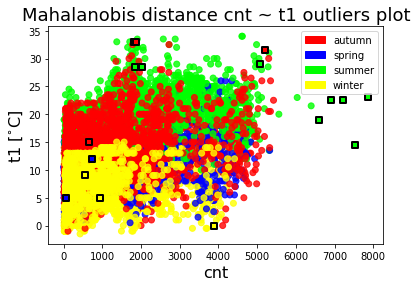

In [91]:
outliers_mahanalobis['cnt~t1'] = calculateOutliers('cnt', 't1')

#### cnt ~ hum

RangeIndex(start=0, stop=17414, step=1)
Valid points on seasons
{'autumn': 'r', 'spring': 'b', 'summer': 'lime', 'winter': 'yellow'}
Outliers on seasons
{'autumn': 'r', 'spring': 'b', 'summer': 'lime', 'winter': 'yellow'}


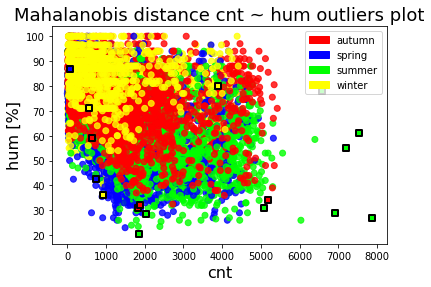

In [92]:
outliers_mahanalobis['cnt~hum'] = calculateOutliers('cnt', 'hum')

#### cnt ~ wind_speed

RangeIndex(start=0, stop=17414, step=1)
Valid points on seasons
{'autumn': 'r', 'spring': 'b', 'summer': 'lime', 'winter': 'yellow'}
Outliers on seasons
{'autumn': 'r', 'spring': 'b', 'summer': 'lime', 'winter': 'yellow'}


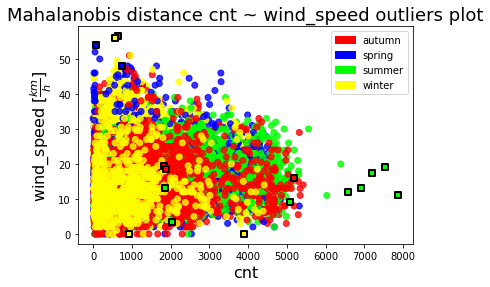

In [93]:
outliers_mahanalobis['cnt~wind_speed'] = calculateOutliers('cnt', 'wind_speed')

Valid points on seasons
{'autumn': 'r', 'spring': 'b', 'summer': 'lime', 'winter': 'yellow'}
Outliers on seasons
{'autumn': 'r', 'spring': 'b', 'summer': 'lime', 'winter': 'yellow'}


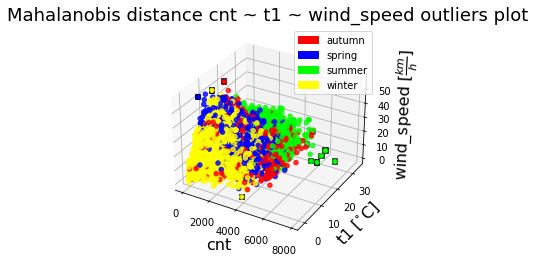

In [94]:
outliers_mahanalobis_3d = calculateOutliers3('cnt', 't1', 'wind_speed')

#### Elementy nietypowe

In [95]:
dataset_mahanalobis = dataset_no_timestamp.copy()
dataset_mahanalobis['mahalanobis'] = mahalanobis(x=dataset_mahanalobis, data=dataset_mahanalobis)

cutoff = scipy.stats.chi2.ppf(q, dataset_mahanalobis['mahalanobis'])
dataset_mahanalobis = dataset_mahanalobis[dataset_mahanalobis['mahalanobis'] < cutoff]

data = dataset.copy()
data['mahalanobis'] = dataset_mahanalobis['mahalanobis']
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.set_option('display.width', 1000)

outliers = data[data['mahalanobis'] < cutoff]
print("Outliers count:", len(outliers))
print(outliers)

Outliers count: 17
                 timestamp   cnt    t1    t2   hum  wind_speed  weather_code  is_holiday  is_weekend  season  mahalanobis
2068   2015-03-31 11:00:00   737  12.0  12.0  42.5        48.0           2.0         0.0         0.0     0.0    29.783664
4250   2015-06-30 13:00:00  1845  28.5  27.0  20.5        13.0           1.0         0.0         0.0     1.0    31.017067
4461   2015-07-09 08:00:00  7531  14.5  14.5  61.0        19.0           2.0         0.0         0.0     1.0    42.726408
4470   2015-07-09 17:00:00  7860  23.0  22.0  27.0        11.0           1.0         0.0         0.0     1.0    43.954082
4471   2015-07-09 18:00:00  6913  22.5  21.5  29.0        13.0           1.0         0.0         0.0     1.0    32.745265
5129   2015-08-06 08:00:00  6585  19.0  19.0  78.0        12.0           7.0         0.0         0.0     1.0    34.990661
5138   2015-08-06 17:00:00  7208  22.5  22.5  55.0        17.5           2.0         0.0         0.0     1.0    34.137869
7597 

### Odrzucenie nietypowych danych

In [96]:
# dataset.drop(index=[*outliers_mahanalobis['cnt~t1'].index], inplace=True, errors='ignore')
# dataset.drop(index=[*outliers_mahanalobis['cnt~hum'].index], inplace=True, errors='ignore')
# dataset.drop(index=[*outliers_mahanalobis['cnt~wind_speed'].index], inplace=True, errors='ignore')


# dataset.shape

# Klasteryzacja

### Dobór liczby klastrów - silhouette score

0.3018448891552829
0.25510407304980803
0.2651017663017713
0.27326418358371934
0.24853642565712722
0.2325807570127198


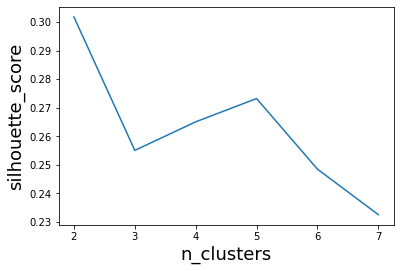

In [97]:
from sklearn.metrics import silhouette_score

scaler = StandardScaler()
data = dataset_no_timestamp.copy()
data = scaler.fit_transform(data)

range_n_clusters = [2, 3, 4, 5, 6, 7]
score = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters).fit(data)
    score.append(silhouette_score(data, kmeans.labels_))
    print(silhouette_score(data, kmeans.labels_))

plt.xlabel("n_clusters", fontsize=18)
plt.ylabel("silhouette_score", fontsize=18)
plt.plot(range_n_clusters, score)
plt.savefig("NClusters.png")

### Metoda k-means

In [98]:
clustersCount = 3

def run_kmeans():
  global clustersCount
  scaler = StandardScaler()
  data = scaler.fit_transform(dataset_no_timestamp)

  kmeans = KMeans(n_clusters=clustersCount).fit(data)
  labels = kmeans.labels_.astype(float)
  dataset['clusters'] = labels
  dataset_no_timestamp['clusters'] = labels

  return scaler.inverse_transform(kmeans.cluster_centers_)

In [99]:
centers = run_kmeans()

### Wykresy

In [100]:
def set_ax(ax, col1, col2, col3 = ""):
  ax.set_xlabel(col1 + get_unit(col1), fontsize=18)
  ax.set_ylabel(col2 + get_unit(col2), fontsize=18)
  if col3:
    ax.set_zlabel(col3 + get_unit(col3), fontsize=18)

def get_axes(col1, col2, col3):
  fig = plt.figure()
  fig.set_size_inches(25, 6)

  ax1 = fig.add_subplot(131, projection='3d')
  ax2 = fig.add_subplot(132)
  ax3 = fig.add_subplot(133)

  set_ax(ax1, col1, col2, col3)
  set_ax(ax2, col1, col2)
  set_ax(ax3, col1, col3)
  plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
  return ax1, ax2, ax3

In [101]:
def print_mean_cluster_values(col1, col2, col3):
  data = dataset_no_timestamp[[col1, col2, col3, 'clusters']]
  print('Mean clusters values')
  print(data.groupby('clusters').mean(), '\n')
  print()

def plot_clusters(col1, col2, col3, ax1, ax2, ax3):
  cmap = plt.cm.brg
  norm = plt.Normalize(dataset_no_timestamp['clusters'].values.min(), dataset_no_timestamp['clusters'].values.max())

  data = dataset_no_timestamp[[col1, col2, col3, 'clusters']].groupby('clusters')
  mean = data.mean()['cnt']
  min = data.min()['cnt']
  max = data.max()['cnt']
  labels = { 0.0 : f"Cnt: Mean={int(mean[0])}, Min={min[0]}, Max={max[0]}",
             1.0 : f"Cnt: Mean={int(mean[1])}, Min={min[1]}, Max={max[1]}",
             2.0 : f"Cnt: Mean={int(mean[2])}, Min={min[2]}, Max={max[2]}" }

  for i, dff in dataset_no_timestamp.groupby('clusters'):
    color = cmap(norm(dff['clusters']))
    ax1.scatter(dff[col1], dff[col2], dff[col3], c=color, s=30, label=labels[i], alpha=0.15)
    ax2.scatter(dff[col1], dff[col2], c=color, s=30, label=labels[i], alpha=0.15)
    ax3.scatter(dff[col1], dff[col3], c=color, s=30, label=labels[i], alpha = 0.15)

  leg2 = ax2.legend(bbox_to_anchor=(0.95, -0.15), fontsize=14)

  for l2 in leg2.legendHandles: 
    l2.set_alpha(1)
    
  ax1.set_title(f"{col1} ~ {col2} ~ {col3} clusterization plot", fontsize=18)
  ax2.set_title(f"{col1} ~ {col2} clusterization plot", fontsize=18)
  ax3.set_title(f"{col1} ~ {col3} clusterization plot", fontsize=18)

def plot_centers(col1, col2, col3, ax1, ax2, ax3):
  col1_index = dataset_no_timestamp.columns.get_loc(col1)
  col2_index = dataset_no_timestamp.columns.get_loc(col2)
  col3_index = dataset_no_timestamp.columns.get_loc(col3)

  ax1.scatter(centers[:, col1_index], centers[:, col2_index], centers[:, col3_index],c='black', s=10)
  ax2.scatter(centers[:, col1_index], centers[:, col2_index], c='black', s=100)
  ax3.scatter(centers[:, col1_index], centers[:, col3_index], c='black', s=100)
  
def plot_kmeans_clusters(col1, col2, col3):
  ax1, ax2, ax3 = get_axes(col1, col2, col3)
  plot_clusters(col1, col2, col3, ax1, ax2, ax3)
  plot_centers(col1, col2, col3, ax1, ax2, ax3)
  print_mean_cluster_values(col1, col2, col3)
  if not isColab:
    plt.savefig(f"./out/clusterization_{col1}_{col2}{(str('_')+col3) if col3 != '' else ''}.jpg")

#### Cnt - t1 - hum

Mean clusters values
                  cnt         t1        hum
clusters                                   
0.0        771.431037   6.754354  77.392549
1.0       2363.061853  18.285160  55.428034
2.0        727.171737  14.317673  78.163719 




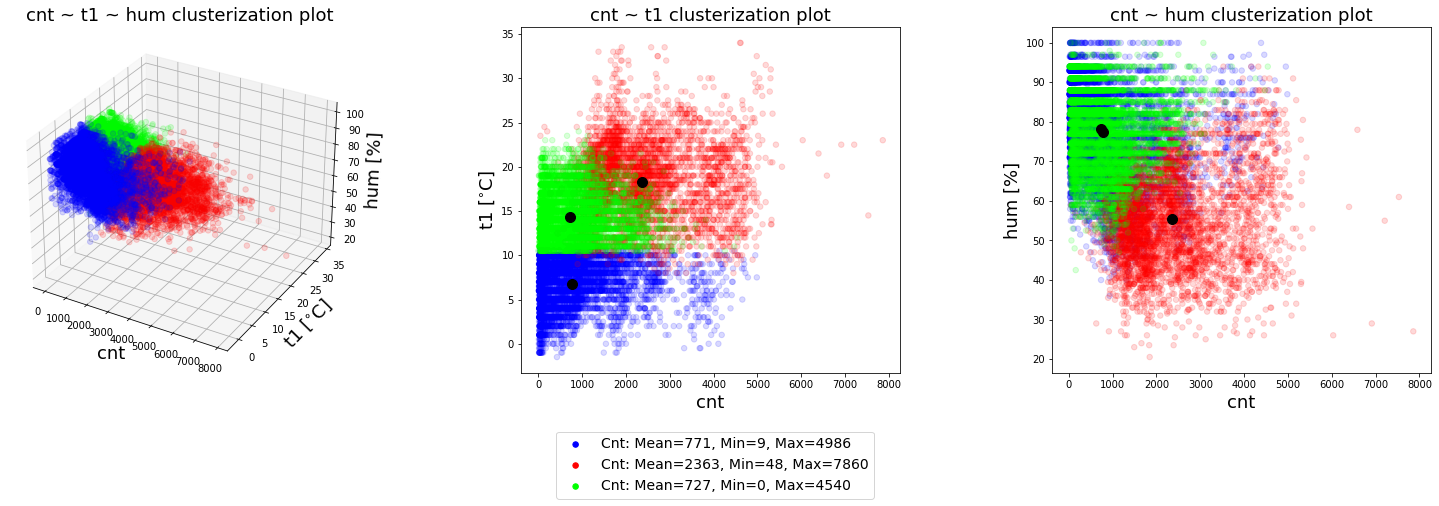

In [102]:
plot_kmeans_clusters('cnt', 't1', 'hum')

#### Cnt - hum - wind_speed

Mean clusters values
                  cnt        hum  wind_speed
clusters                                    
0.0        771.431037  77.392549   14.489431
1.0       2363.061853  55.428034   18.524341
2.0        727.171737  78.163719   15.633548 




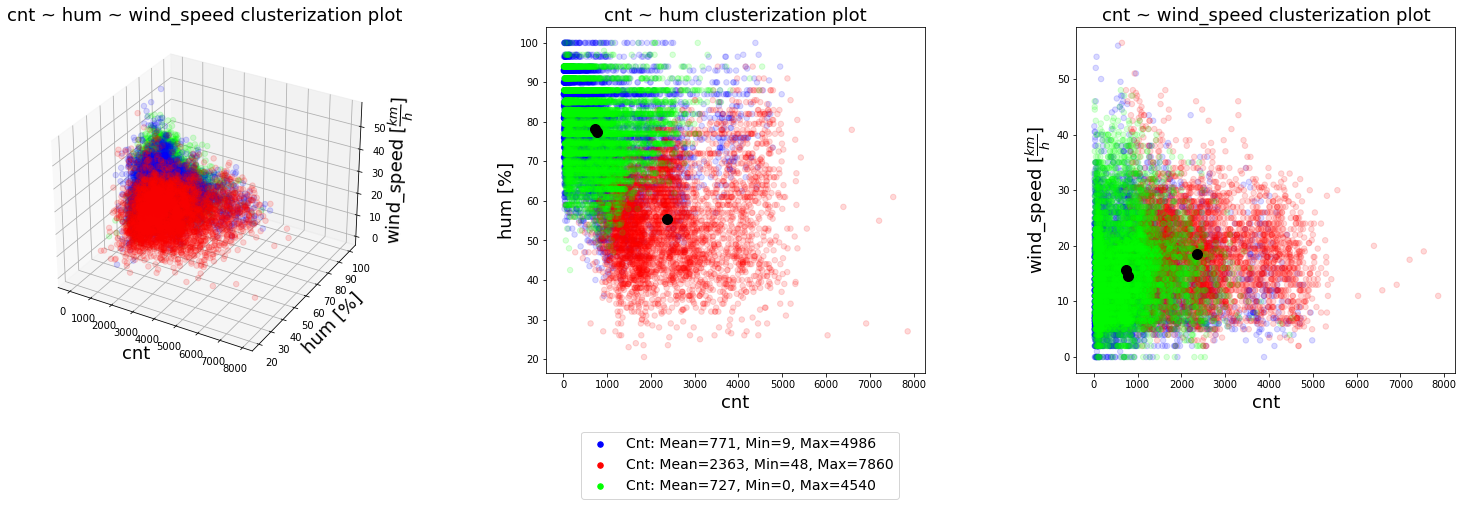

In [103]:
plot_kmeans_clusters('cnt', 'hum', 'wind_speed')

Mean clusters values
                  cnt         t1        hum
clusters                                   
0.0        771.431037   6.754354  77.392549
1.0       2363.061853  18.285160  55.428034
2.0        727.171737  14.317673  78.163719 




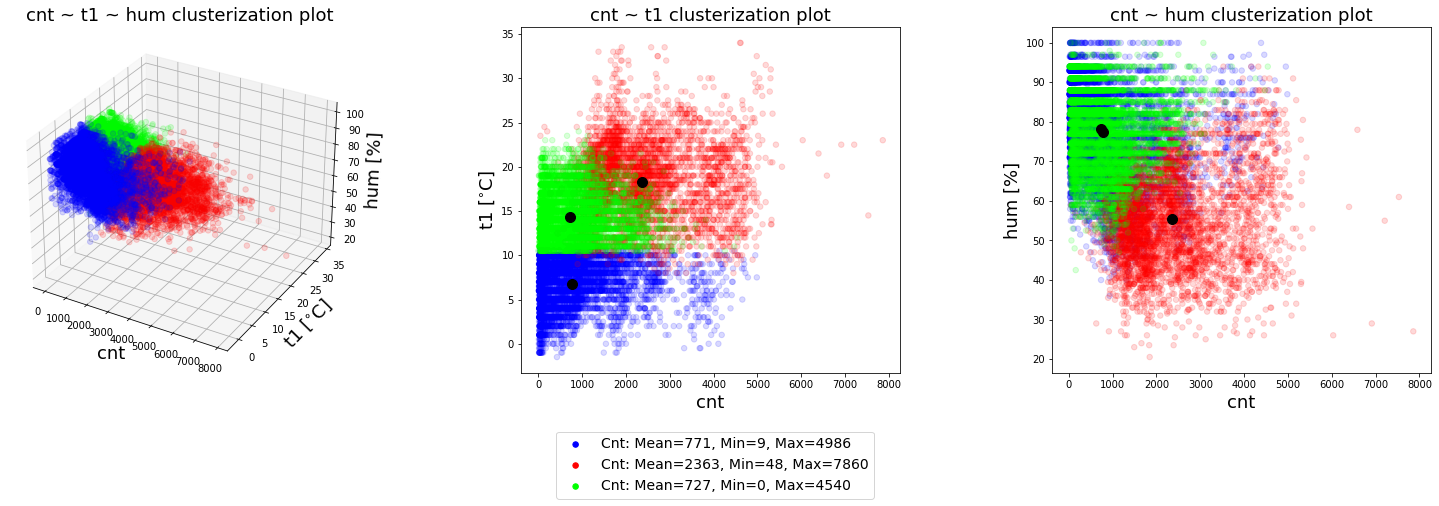

In [104]:
plot_kmeans_clusters('cnt', 't1', 'hum')

### Klastry i kategorie

In [105]:
from scipy.spatial import ConvexHull

def plot_clusters_with_category(col1, col2, dataCol1, dataCol2, colors, categoryName, ax):
  data = dataset[[col1, col2, 'clusters']]

  set_ax(ax, col1, col2)
  ax.set_title(categoryName, fontsize=18)
  ax.scatter(dataCol1, dataCol2, c=colors[0], alpha = 0.6, s=50)
  ax.legend(handles= [mpatches.Patch(color=color, label=label) for color, label in {val: key for key, val in colors[1].items()}.items()])
  for i in range(clustersCount):
      points = data[data.clusters == i][[col1, col2]].values
      hull = ConvexHull(points)
      x_hull = np.append(points[hull.vertices,0],
                         points[hull.vertices,0][0])
      y_hull = np.append(points[hull.vertices,1],
                         points[hull.vertices,1][0])
      ax.fill(x_hull, y_hull, alpha=0.35)


In [106]:
from datetime import datetime

def get_not_work_hours():
  workHours = [ 7, 8, 9, 15, 16, 17 ]
  dateList = [datetime.strptime(date[0], '%Y-%m-%d %H:%M:%S') for date in dataset[['timestamp']].values]
  return [(date.hour not in workHours) for date in dateList]

def plot_weekend_holiday_clusters(col1, col2, ax):
  name = 'Bike rentals on holidays and weekend days'
  data = dataset['is_weekend'].astype(bool) | dataset['is_holiday'].astype(bool)
  plot_clusters_with_category(col1, col2, dataset_no_timestamp[col1], dataset_no_timestamp[col2], colors(data, name), name, ax)

def plot_not_working_hours(col1, col2, ax):
  name = 'Bike rentals on working hours'
  data = get_not_work_hours() | dataset['is_weekend'].astype(bool) | dataset['is_holiday'].astype(bool)
  plot_clusters_with_category(col1, col2, dataset_no_timestamp[col1], dataset_no_timestamp[col2], colors(data, name), name, ax)

def plot_weather_clusters(col1, col2, ax):
  name = 'Bike rentals depending on weather'

  # 1 - Czyste niebo / czyste z nielicznymi zjawiskami, jak lekka mgła itp.
  # 2 - Obecne chmury
  # 3 - Promienie przedzierające się przez chmury (chmury pokrywające 60-90 % nieba)
  # 4 - Pochmurno
  # 7 - Deszcz/mżawka
  # 10 - Deszcz z burzą
  # 26 - Opad śniegu
  # 94 - mgła lodowa
 
  data = [weather[code] for code in dataset['weather_code']]
  plot_clusters_with_category(col1, col2, dataset_no_timestamp[col1], dataset_no_timestamp[col2], colors(list(map(lambda x: weather_string[x], data)), name), name, ax)

def plot_season_clusters(col1, col2, ax):
  name = 'Bike rentals on seasons'
  plot_clusters_with_category(col1, col2, dataset_no_timestamp[col1], dataset_no_timestamp[col2], colors(list(map(lambda x: seasons_string[x], dataset['season'])), name), name, ax)

def plot_clusters_with_categories(col1, col2):
  fig = plt.figure()
  fig.set_size_inches(20, 20)

  ax1 = fig.add_subplot(221)
  ax2 = fig.add_subplot(222)
  ax3 = fig.add_subplot(223)
  ax4 = fig.add_subplot(224)

  plot_weekend_holiday_clusters(col1, col2, ax1)
  plot_not_working_hours(col1, col2, ax2)
  plot_weather_clusters(col1, col2, ax3)
  plot_season_clusters(col1, col2, ax4)
  if not isColab:
    plt.savefig(f"./out/categorization_{col1}_{col2}.jpg")

#### cnt - t1

Bike rentals on holidays and weekend days
{False: 'r', True: 'b'}
Bike rentals on working hours
{False: 'r', True: 'b'}
Bike rentals depending on weather
{'Bad': 'r', 'Good': 'b', 'Medium': 'lime'}
Bike rentals on seasons
{'autumn': 'r', 'spring': 'b', 'summer': 'lime', 'winter': 'yellow'}


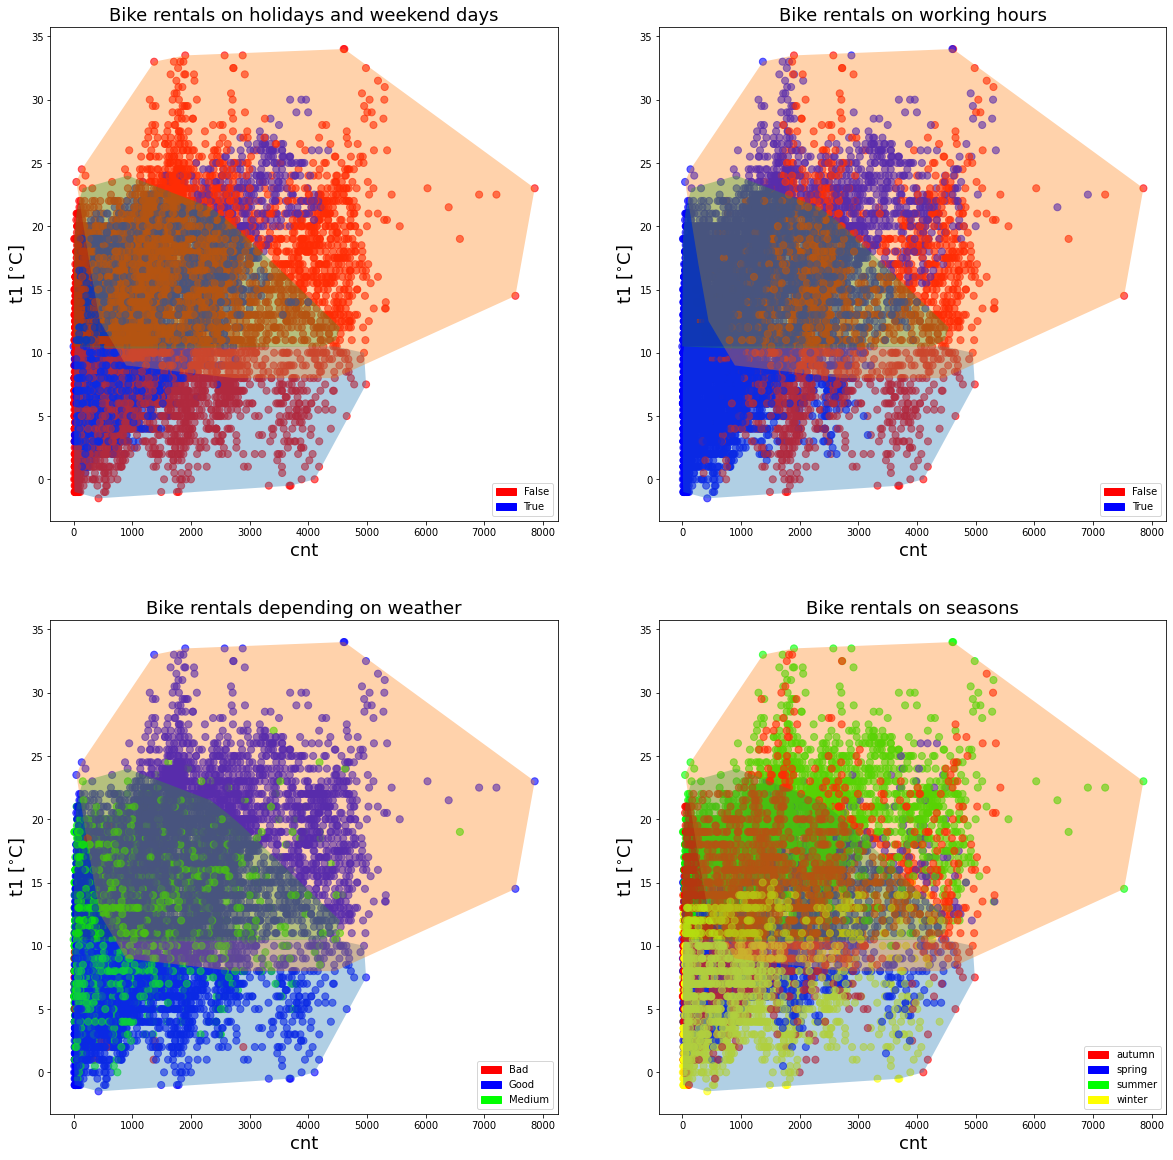

In [107]:
plot_clusters_with_categories('cnt', 't1')

#### cnt - hum

Bike rentals on holidays and weekend days
{False: 'r', True: 'b'}
Bike rentals on working hours
{False: 'r', True: 'b'}
Bike rentals depending on weather
{'Bad': 'r', 'Good': 'b', 'Medium': 'lime'}
Bike rentals on seasons
{'autumn': 'r', 'spring': 'b', 'summer': 'lime', 'winter': 'yellow'}


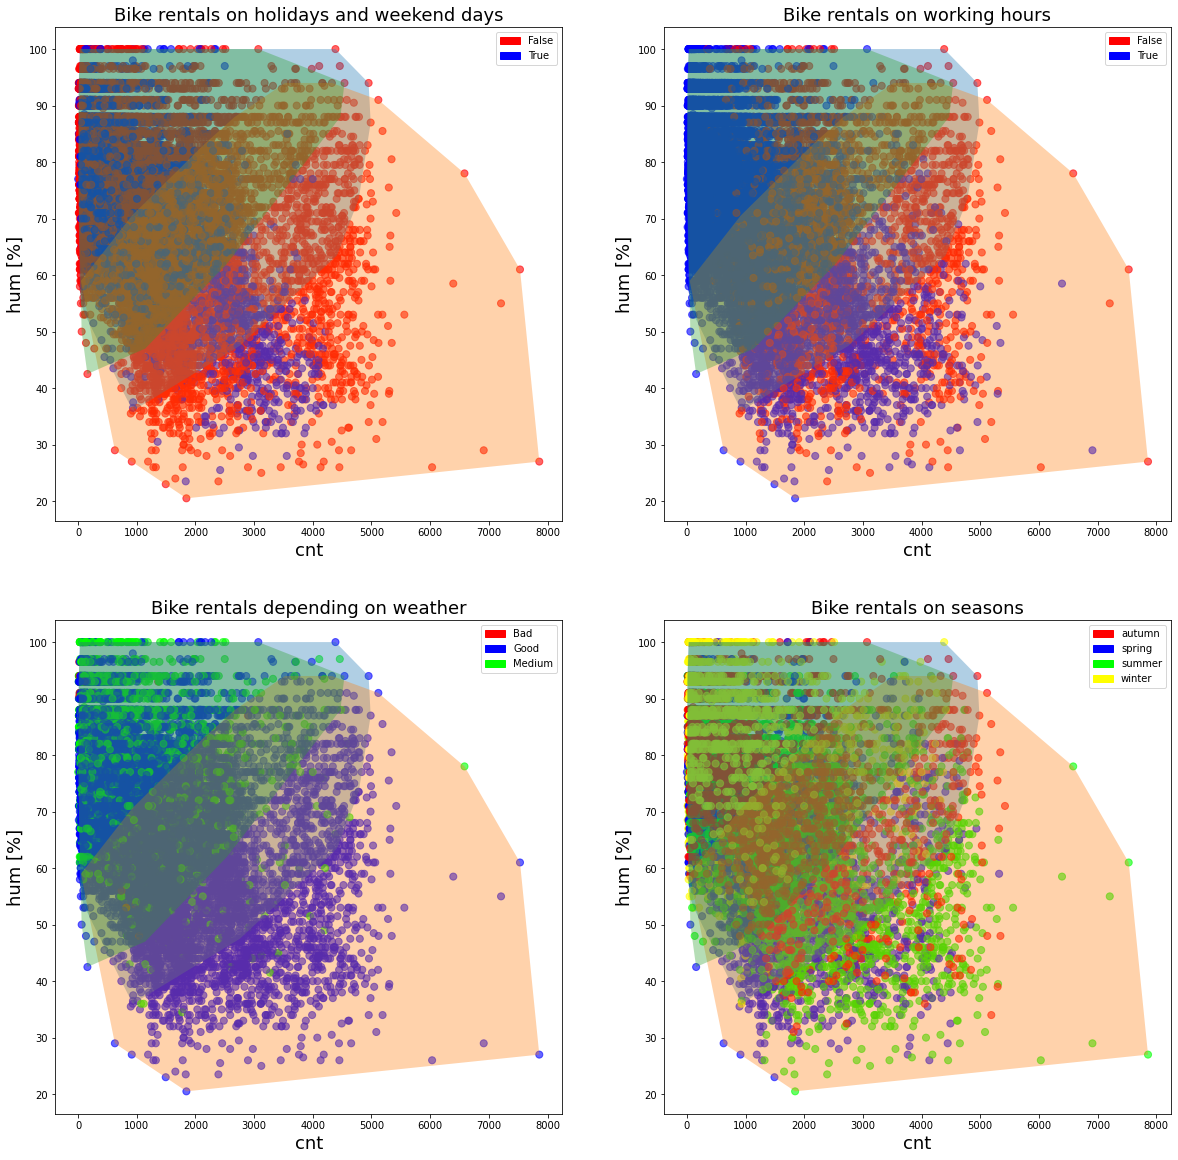

In [108]:
plot_clusters_with_categories('cnt', 'hum')

#### cnt - wind_speed

Bike rentals on holidays and weekend days
{False: 'r', True: 'b'}
Bike rentals on working hours
{False: 'r', True: 'b'}
Bike rentals depending on weather
{'Bad': 'r', 'Good': 'b', 'Medium': 'lime'}
Bike rentals on seasons
{'autumn': 'r', 'spring': 'b', 'summer': 'lime', 'winter': 'yellow'}


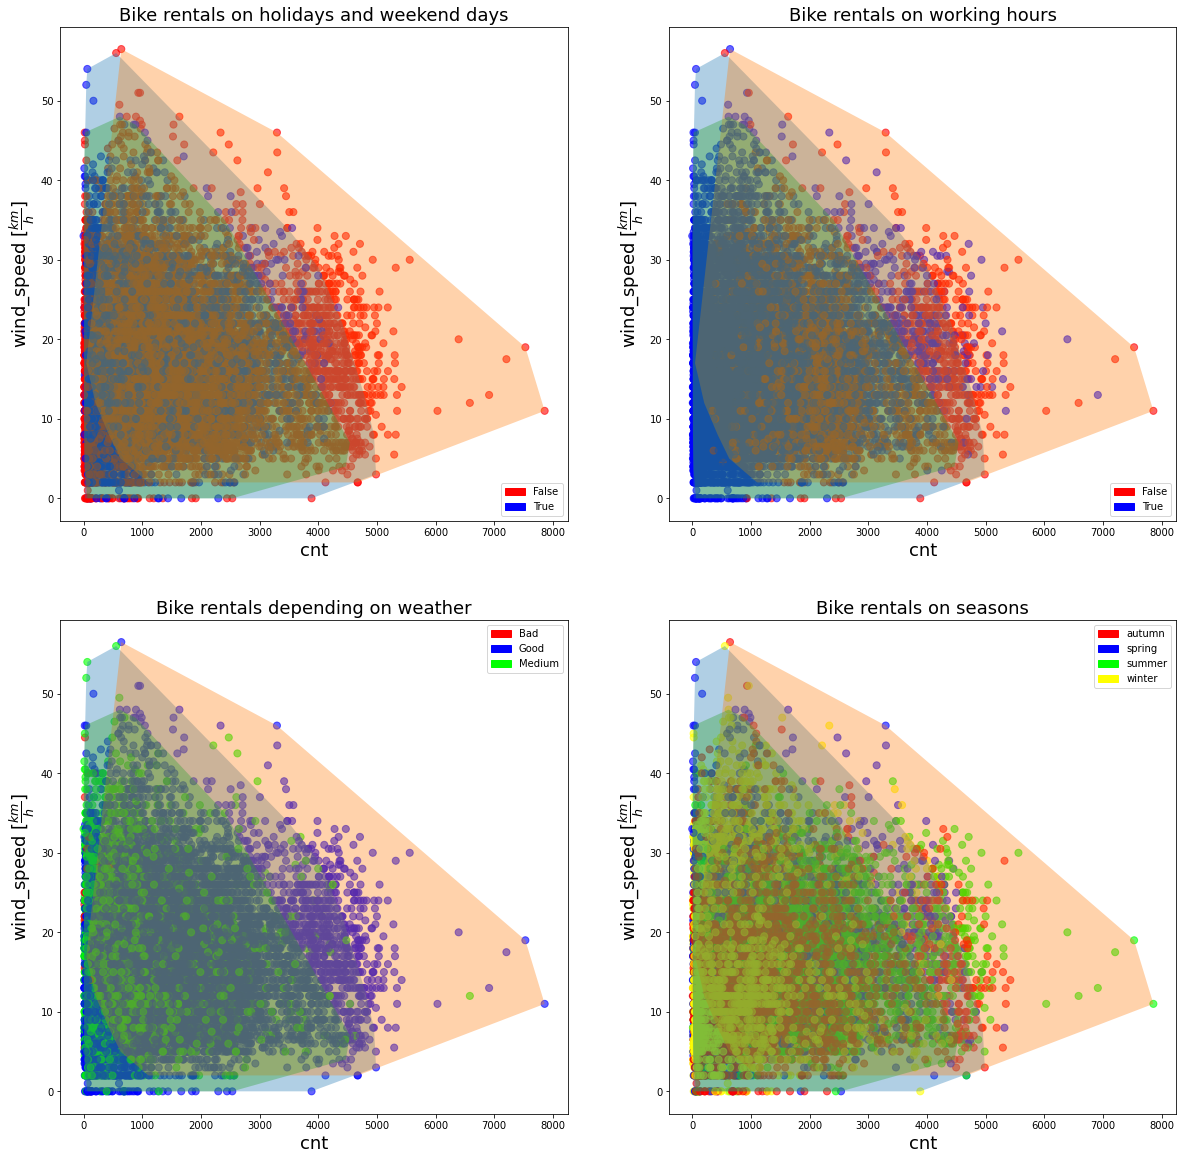

In [109]:
plot_clusters_with_categories('cnt', 'wind_speed')

# Klasyfikacja

In [110]:
testSize = 0.2

def split_data():
  X = dataset_no_timestamp.drop('clusters', axis=1)
  Y = dataset_no_timestamp.clusters
  return train_test_split(X, Y, test_size=testSize)

### Liczba sąsiadów a dokładność

Text(0.5, 1.0, 'Classification accuracy referring neighbours count')

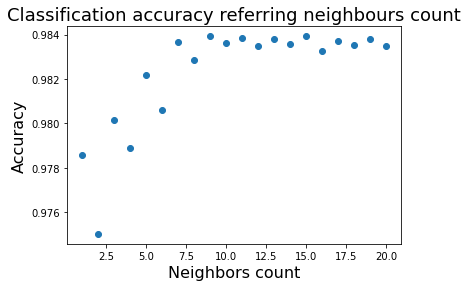

In [111]:
total_accuracy = []

for i in range(10):
  X_train, X_test, Y_train, Y_test = split_data()

  scaler = StandardScaler()
  scaler.fit(X_train)
  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)

  neighbors = np.arange(1, 21)
  accuracy = []

  for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test)
    accuracy.append(metrics.accuracy_score(Y_pred, Y_test))

  total_accuracy.append(accuracy)

total_accuracy = np.array(total_accuracy)
plt.scatter(neighbors, [sum(total_accuracy[:,i]) / 10 for i in range(20)])
plt.xlabel('Neighbors count', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Classification accuracy referring neighbours count', fontsize=18)

### Metoda K-najbliższych sąsiadów

In [112]:
neighborsCount = 6

def run_knn():
  X_train, X_test, Y_train, Y_test = split_data()

  scaler = StandardScaler()
  scaler.fit(X_train)
  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)

  knn = KNeighborsClassifier(n_neighbors=neighborsCount) 
  knn.fit(X_train, Y_train)

  Y_pred = knn.predict(X_test)
  X_test = scaler.inverse_transform(X_test)

  return X_train, X_test, Y_train, Y_test, Y_pred

### Wyniki

In [113]:
X_train, X_test, Y_train, Y_test, Y_pred = run_knn()
print("KNN accuracy:", metrics.accuracy_score(Y_test, Y_pred))

KNN accuracy: 0.9799023830031582


In [114]:
def plot_KNN_results(col1, col2):
  fig, ax = plt.subplots()
  fig.set_size_inches(10, 10)

  name = f"{col2}~{col1} classification"
  col1_index = dataset_no_timestamp.columns.get_loc(col1)
  col2_index = dataset_no_timestamp.columns.get_loc(col2)

  col1Data = X_test[:,col1_index]
  col2Data = X_test[:,col2_index]

  temp_dict = {0.0: 'c1', 1.0: 'c2', 2.0: 'c3'}
  
  plot_clusters_with_category(col1, col2, col1Data, col2Data, colors(list(map(lambda x: temp_dict[x], Y_pred)), name), name, ax)
  if not isColab:
    plt.savefig(f"./out/classifictaion_{name}.jpg")

t1~cnt classification
{'c1': 'r', 'c2': 'b', 'c3': 'lime'}


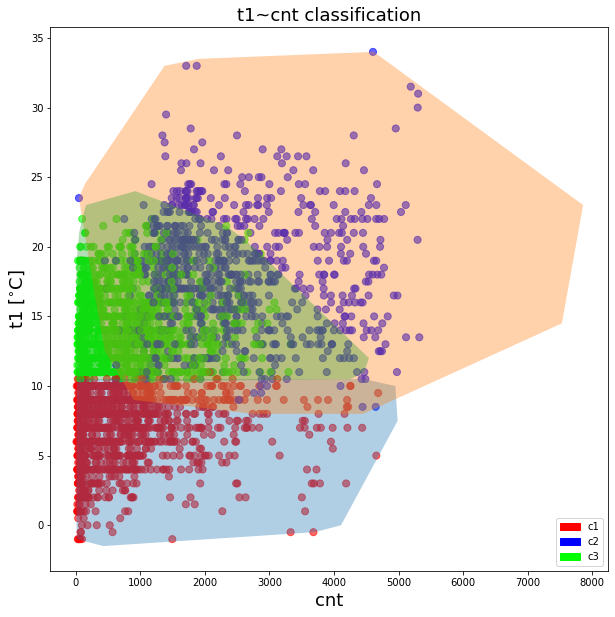

In [115]:
plot_KNN_results('cnt', 't1')

hum~cnt classification
{'c1': 'r', 'c2': 'b', 'c3': 'lime'}


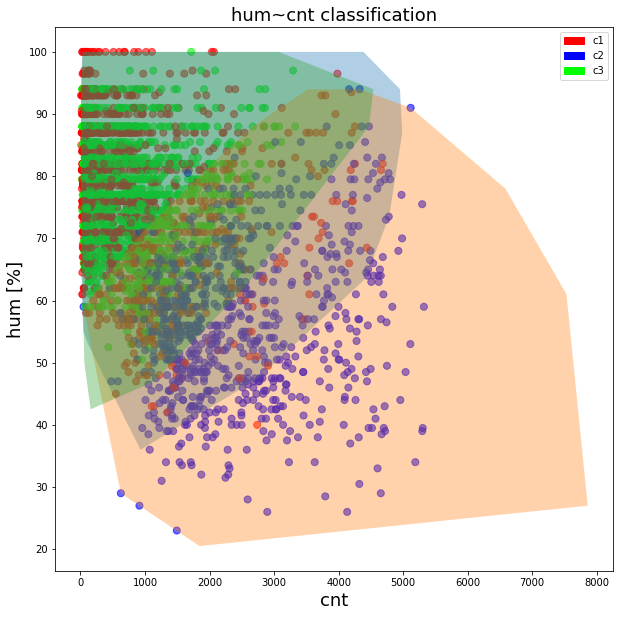

In [116]:
plot_KNN_results('cnt', 'hum')

wind_speed~cnt classification
{'c1': 'r', 'c2': 'b', 'c3': 'lime'}


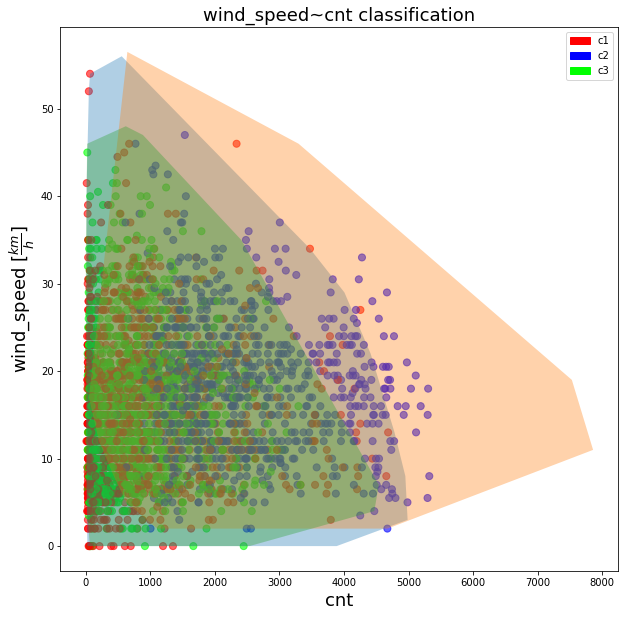

In [117]:
plot_KNN_results('cnt', 'wind_speed')

# Przewidywanie liczby rowerów

In [125]:
testSize = 0.2

def set_cnt_category(row):
  if row['cnt'] < 1000:
    val = 0
  elif row['cnt'] < 2000:
    val = 1
  elif row['cnt'] < 3000:
    val = 2 
  elif row['cnt'] < 4000:
    val = 3
  elif row['cnt'] < 5000:
    val = 4
  else:
    val = 5
  return val

def split_cnt_data():
  data = dataset[['cnt', 't1', 't2', 'hum', 'wind_speed']]
  Y = data.apply(set_cnt_category, axis=1)
  X = data.drop('cnt', axis=1)
  return train_test_split(X, Y, test_size=testSize)

def split_cnt_day_data():
  hourList = [datetime.strptime(date[0], '%Y-%m-%d %H:%M:%S').hour for date in dataset[['timestamp']].values]
  data = dataset.copy()
  data['hours'] = hourList
  data = data[(data.hours > 5) & (data.hours < 23)]
  data = data[['cnt', 't1', 't2', 'hum', 'wind_speed']]
  Y = data.apply(set_cnt_category, axis=1)
  X = data.drop('cnt', axis=1)
  return train_test_split(X, Y, test_size=testSize)

### Liczba sąsiadów a dokładność

In [119]:
def calculate_accuracy_score(split_function):
  total_accuracy = []

  for i in range(10):
    X_train, X_test, Y_train, Y_test = split_function()

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    neighbors = np.arange(1, 21)
    accuracy = []

    for n in neighbors:
      knn = KNeighborsClassifier(n_neighbors=n)
      knn.fit(X_train, Y_train)
      Y_pred = knn.predict(X_test)
      accuracy.append(metrics.accuracy_score(Y_pred, Y_test))

    total_accuracy.append(accuracy)

  total_accuracy = np.array(total_accuracy)
  plt.scatter(neighbors, [sum(total_accuracy[:,i]) / 10 for i in range(20)])
  plt.xlabel('Neighbors count', fontsize=16)
  plt.ylabel('Accuracy', fontsize=16)
  plt.title('Classification accuracy referring neighbours count', fontsize=18)

### Metoda K-najbliższych sąsiadów

In [120]:
def run_cnt_knn(split_function, neighborsCount):
  X_train, X_test, Y_train, Y_test = split_function()

  scaler = StandardScaler()
  scaler.fit(X_train)
  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)

  knn = KNeighborsClassifier(n_neighbors=neighborsCount) 
  knn.fit(X_train, Y_train)

  Y_pred = knn.predict(X_test)
  X_test = scaler.inverse_transform(X_test)

  return X_train, X_test, Y_train, Y_test, Y_pred

## Przewidywanie na podstawie wszystkich danych

### Liczba sąsiadów a dokładność

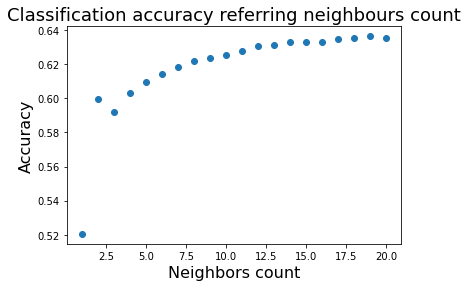

In [121]:
calculate_accuracy_score(split_cnt_data)

### Wyniki

In [122]:
neighborsCount = 14
X_trainCnt, X_testCnt, Y_trainCnt, Y_testCnt, Y_predCnt = run_cnt_knn(split_cnt_data, neighborsCount)
print("KNN accuracy:", metrics.accuracy_score(Y_testCnt, Y_predCnt))

KNN accuracy: 0.6474303761125466


## Przewidywanie na podstawie danych dziennych (godziny 6-22)

### Liczba sąsiadów a dokładność

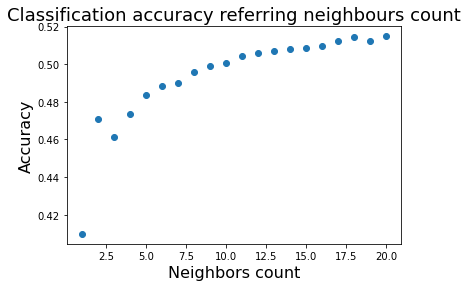

In [123]:
calculate_accuracy_score(split_cnt_day_data)

### Wyniki

In [124]:
neighborsCount = 16
X_trainCntDay, X_testCntDay, Y_trainCntDay, Y_testCntDay, Y_predCntDay = run_cnt_knn(split_cnt_day_data, neighborsCount)
print("KNN accuracy:", metrics.accuracy_score(Y_testCntDay, Y_predCntDay))

KNN accuracy: 0.5016181229773463
